## Sommaire : Tests de modèles <a class="anchor" id="Sommaire"></a>

* [Chargement des données](#Partie1)
* [Modèles pour la consommation d'énergie](#Partie2)
    * [Préparation des données](#Partie2_1)
    * [Régression Linéaire (Baseline)](#Partie2_2)         
    * [Sélection des variables](#Partie2_3)
    * [Régression Ridge](#Partie2_4)
    * [Forêt aléatoire](#Partie2_5)
    * [Comparaison des modèles](#Partie2_6)
* [Modèles pour les émissions de CO2](#Partie3)
    * [Préparation des données](#Partie3_1)
    * [Régression Linéaire (Baseline)](#Partie3_2)         
    * [Sélection des variables](#Partie3_3)
    * [Régression Ridge](#Partie3_4)
    * [Forêt aléatoire](#Partie3_5)
    * [Comparaison des modèles](#Partie3_6)
* [Impact de l'EnergyStarScore](#Partie4)
    * [Préparation des données](#Partie4_1)
    * [Mise en place du modèle](#Partie4_2)
    * [Comparaison des modèles](#Partie4_3)

## Chargement des données <a class="anchor" id="Partie1"></a>

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import missingno as msno
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_Elec = pd.read_csv('df_Elec.csv', sep=",")
df_Elec.shape

(2150, 17)

In [3]:
df_Elec.head()

,BuildingType,PrimaryPropertyType,LargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions(Tons),SiteEnergyUse(log),TotalGHGEmissions(log)
0,2,4,4,1.0,12.0,88434,0,88434,88434.0,2023032.0,3686160.0,1272388.0,65.0,6981428.0,249.43,15.758764,5.519178
1,2,4,4,1.0,11.0,103566,15064,88502,83880.0,0.0,3905411.0,4448985.0,51.0,8354235.0,263.51,15.938279,5.574091
2,2,4,4,1.0,41.0,961990,0,961990,757243.0,19660404.0,49762435.0,3709900.0,18.0,73130656.0,2061.48,18.107758,7.631179
3,2,4,4,1.0,10.0,61320,0,61320,61320.0,23458518.0,2769023.0,2001894.0,1.0,28229320.0,1936.34,17.155872,7.568555
4,2,4,4,1.0,18.0,119890,12460,107430,123445.0,0.0,6066245.0,8763105.0,67.0,14829099.0,507.70,16.512102,6.229891


#### One hot encoder

In [4]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
encoder_df = pd.DataFrame(encoder.fit_transform(df_Elec[['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType']]))
encoder_df.columns = ['BuildingType_1', 'BuildingType_2', 'BuildingType_5',
                      'PrimaryPropertyType_0', 'PrimaryPropertyType_1', 'PrimaryPropertyType_2',
                      'PrimaryPropertyType_3', 'PrimaryPropertyType_4', 'PrimaryPropertyType_5',
                      'LargestPropertyUseType_0', 'LargestPropertyUseType_1', 'LargestPropertyUseType_2',
                      'LargestPropertyUseType_3', 'LargestPropertyUseType_4', 'LargestPropertyUseType_5']

df_Elec_ = encoder_df.join(df_Elec.iloc[:, 3:])
df_Elec_.head()

,BuildingType_1,BuildingType_2,BuildingType_5,PrimaryPropertyType_0,PrimaryPropertyType_1,PrimaryPropertyType_2,PrimaryPropertyType_3,PrimaryPropertyType_4,PrimaryPropertyType_5,LargestPropertyUseType_0,...,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions(Tons),SiteEnergyUse(log),TotalGHGEmissions(log)
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,88434,88434.0,2023032.0,3686160.0,1272388.0,65.0,6981428.0,249.43,15.758764,5.519178
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,88502,83880.0,0.0,3905411.0,4448985.0,51.0,8354235.0,263.51,15.938279,5.574091
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,961990,757243.0,19660404.0,49762435.0,3709900.0,18.0,73130656.0,2061.48,18.107758,7.631179
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,61320,61320.0,23458518.0,2769023.0,2001894.0,1.0,28229320.0,1936.34,17.155872,7.568555
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,107430,123445.0,0.0,6066245.0,8763105.0,67.0,14829099.0,507.70,16.512102,6.229891


[Retour au sommaire](#Sommaire)
## Modèles pour la consommation d'énergie <a class="anchor" id="Partie2"></a>
### Préparation des données <a class="anchor" id="Partie2_1"></a>
#### Séparation en données d'entraînement et de test
Nos variables cibles sont ```SiteEnergyUse(log)``` et ```TotalGHGEmissions(log)```.
Nous excluons la variable ```ENERGYSTARScore``` de notre entraînement,  nous l'utiliserons plus tard.
Toutes les autres variables sont nos variables d'entraînement.


In [5]:
from sklearn.model_selection import train_test_split

X_energy = df_Elec_.iloc[:,0:-3]
y_energy = df_Elec_.iloc[:,-2]

X_train_energy_, X_test_energy_, y_train_energy_, y_test_energy_ = train_test_split(X_energy, y_energy, test_size=0.3,
                                                                                    random_state=42)

X_train_energy_ = X_train_energy_.reset_index(drop=True)
X_test_energy_ = X_test_energy_.reset_index(drop=True)
y_train_energy_ = y_train_energy_.reset_index(drop=True)
y_test_energy_ = y_test_energy_.reset_index(drop=True)

In [6]:
print(X_train_energy_.shape)
print(X_test_energy_.shape)
print(y_train_energy_.shape)
print(y_test_energy_.shape)

(1505, 26)
(645, 26)
(1505,)
(645,)


In [7]:
X_train_energy_.head()

,BuildingType_1,BuildingType_2,BuildingType_5,PrimaryPropertyType_0,PrimaryPropertyType_1,PrimaryPropertyType_2,PrimaryPropertyType_3,PrimaryPropertyType_4,PrimaryPropertyType_5,LargestPropertyUseType_0,...,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ENERGYSTARScore,SiteEnergyUse(kBtu)
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,7.0,277486,80283,197203,178625.0,0.0,12729856.0,0.0,63.0,12729858.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,103000,0,103000,103000.0,0.0,2338435.0,2515995.0,42.0,4854429.5
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,24152,0,24152,24152.0,0.0,50897.0,0.0,100.0,56493.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,15.0,115775,31535,84240,150000.0,0.0,2892548.0,0.0,93.0,2892428.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,23500,0,23500,23500.0,0.0,1170650.0,470945.0,28.0,1641546.0


In [8]:
y_train_energy_.head()

0    16.359461
1    15.395402
2    10.941872
3    14.877607
4    14.311149
Name: SiteEnergyUse(log), dtype: float64

#### Standardisation des variables numériques
Nous allons standardiser toutes nos variables numériques de ```X_train_energy_``` c'est à dire toutes les variables sauf ```LargestPropertyUseType``` qui est une variable catégorielle.

In [9]:
from sklearn import preprocessing
std_scale_X = preprocessing.StandardScaler().fit(X_train_energy_.iloc[:, 15:-2])
X_train_std1 = std_scale_X.transform(X_train_energy_.iloc[:, 15:-2])
X_test_std1 = std_scale_X.transform(X_test_energy_.iloc[:, 15:-2])

std_scale_y = preprocessing.StandardScaler().fit(np.array(y_train_energy_).reshape(-1, 1))
y_train_std1 = std_scale_y.transform(np.array(y_train_energy_).reshape(-1, 1))
y_test_std1 = std_scale_y.transform(np.array(y_test_energy_).reshape(-1, 1))

In [10]:
X_train_energy = X_train_energy_.iloc[:, :15].join(pd.DataFrame(X_train_std1))
X_train_energy.columns = X_train_energy_.columns[:-2]
X_test_energy = X_test_energy_.iloc[:, :15].join(pd.DataFrame(X_test_std1))
X_test_energy.columns = X_train_energy_.columns[:-2]

In [11]:
y_data_train1 = pd.DataFrame(y_train_std1)
y_data_train1.columns = ['SiteEnergyUse(log)']
y_train_energy = y_data_train1['SiteEnergyUse(log)']

y_data_test1 = pd.DataFrame(y_test_std1)
y_data_test1.columns = ['SiteEnergyUse(log)']
y_test_energy = y_data_test1['SiteEnergyUse(log)']

In [12]:
X_train_energy.head()

,BuildingType_1,BuildingType_2,BuildingType_5,PrimaryPropertyType_0,PrimaryPropertyType_1,PrimaryPropertyType_2,PrimaryPropertyType_3,PrimaryPropertyType_4,PrimaryPropertyType_5,LargestPropertyUseType_0,...,LargestPropertyUseType_5,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.041924,0.241847,0.683601,1.313040,0.448974,0.411667,-0.088979,0.424304,-0.190467
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,-0.041924,-0.241365,-0.126173,-0.333263,-0.058963,-0.027697,-0.088979,-0.232315,0.053322
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.041924,-0.362168,-0.492100,-0.333263,-0.484107,-0.485786,-0.088979,-0.376861,-0.190467
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.041924,1.208271,-0.066885,0.313401,-0.160116,0.245363,-0.088979,-0.197302,-0.190467
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.041924,-0.362168,-0.495126,-0.333263,-0.487622,-0.489574,-0.088979,-0.306106,-0.144835


[Retour au sommaire](#Sommaire)

### Régression Linéaire (Baseline) <a class="anchor" id="Partie2_2"></a>

In [14]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
import timeit

np.random.seed(5)
cv_train = KFold(n_splits = 5, shuffle = True, random_state = 45)
score = ('r2','neg_mean_absolute_error')
param_lr = {'fit_intercept' : [True, False],
            'normalize': [True, False]
           }
lr = GridSearchCV(LinearRegression(),
                  param_grid = param_lr,            
                  verbose = 2,
                  cv = cv_train,
                  scoring = score,
                  refit = 'neg_mean_absolute_error',
                  return_train_score = True,
                  n_jobs = -1
                 )

lr.fit(X_train_energy, y_train_energy)
pred_lr = lr.predict(X_test_energy)

print('Meilleurs hyperparamètres : ' + str(lr.best_params_))

fit_time_lr = lr.cv_results_['mean_fit_time'].mean()
pred_time_lr = lr.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr))

def RSE(pred, y_test):
    y_barre = np.mean(y_test)
    RSE = sum((y_test - pred)**2)/sum((y_test - y_barre)**2)
    return RSE

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': False, 'normalize': True}
Temps écoulé pour l'entraînement = 0.04s
Temps écoulé pour la prédiction = 0.00s


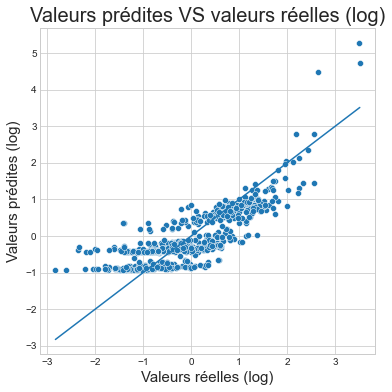

In [15]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_energy, y = pred_lr)
plt.plot([y_test_energy.min(), y_test_energy.max()], [y_test_energy.min(), y_test_energy.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

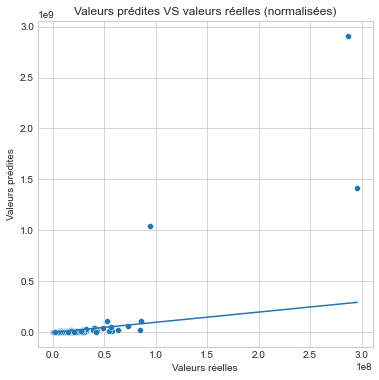

In [28]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(pred_lr.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [30]:
outliers = pd.DataFrame(np.exp(std_scale_y.inverse_transform(pred_lr.reshape(-1, 1))).reshape(-1, ))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

,prédictions
96,2.907265e+09
5,1.413293e+09
505,1.047113e+09
341,1.170072e+08
108,1.148008e+08


In [31]:
X_test_energy_plot = X_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
y_test_energy_plot = y_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr).drop([5, 96, 505]).reset_index(drop=True)

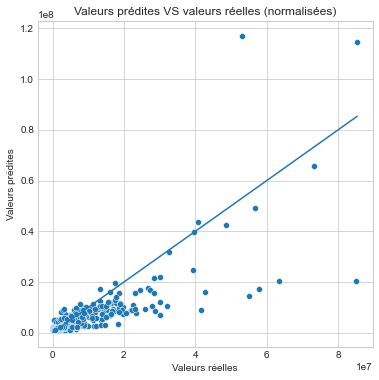

In [36]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_plot['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error as mae

# On enregistre l'erreur de notre régression comme une baseline
baseline_error = mean_squared_error(y_test_energy, pred_lr, squared=True)
print('MSE = {:.2f}'.format(baseline_error))
print('RMSE = {:.2f}'.format(baseline_error**(1/2)))

R2_lr = r2_score(y_test_energy, pred_lr)
print('Coefficient de détermination = {:.2f}'.format(R2_lr))

MSE = 0.32
RMSE = 0.57
Coefficient de détermination = 0.64


[Retour au sommaire](#Sommaire)

### Sélection des variables  <a class="anchor" id="Partie2_3"></a>
Essayons d'entraîner une régression linéaire avec des combinaisons de variables différentes.

* [Sans les catégories de bâtiments](#Petit1)
* [Sans les données d'énergie](#Petit2)
* [Sans les catégories de bâtiments ni les données d'énergie](#Petit3)
* [Sans *BuildingType* ni les données d'énergie](#Petit4)
* [Sans *PrimaryPropertyType* ni les données d'énergie](#Petit5)
* [Sans *LargestPropertyUseType* ni les données d'énergie](#Petit6)
* [Sans *BuildingType* et *PrimaryPropertyType* ni les données d'énergie](#Petit7)
* [Sans *BuildingType* et *LargestPropertyUseType* ni les données d'énergie](#Petit8)
* [Sans *PrimaryPropertyType* et *LargestPropertyUseType* ni les données d'énergie](#Petit9)
* [Seulement avec les données d'énergie](#Petit10)
* [Comparaison des modèles](#Comp)

**1. Sans les catégories de bâtiments** <a class="anchor" id="Petit1"></a>

In [38]:
X_train_energy_without_cat = X_train_energy.iloc[:, 15:]
X_test_energy_without_cat = X_test_energy.iloc[:, 15:]

np.random.seed(5)
lr_without_cat = GridSearchCV(LinearRegression(),
                              param_grid = param_lr,            
                              verbose = 2,
                              cv = cv_train,
                              scoring = score,
                              refit = 'neg_mean_absolute_error',
                              return_train_score = True,
                              n_jobs = -1
                             )

lr_without_cat.fit(X_train_energy_without_cat, y_train_energy)
pred_lr_without_cat = lr_without_cat.predict(X_test_energy_without_cat)

print('Meilleurs hyperparamètres : ' + str(lr_without_cat.best_params_))

fit_time_lr_without_cat = lr_without_cat.cv_results_['mean_fit_time'].mean()
pred_time_lr_without_cat = lr_without_cat.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_without_cat))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_without_cat))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': False, 'normalize': True}
Temps écoulé pour l'entraînement = 0.02s
Temps écoulé pour la prédiction = 0.00s


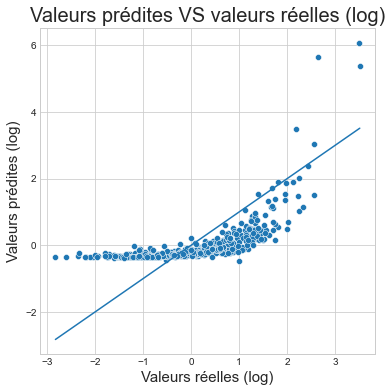

In [40]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_energy, y = pred_lr_without_cat)
plt.plot([y_test_energy.min(), y_test_energy.max()], [y_test_energy.min(), y_test_energy.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

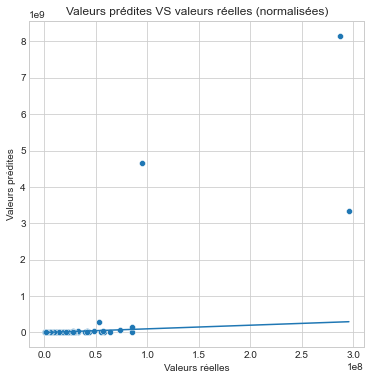

In [42]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(pred_lr_without_cat.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [43]:
outliers = pd.DataFrame(np.exp(pred_lr_without_cat))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

,prédictions
96,433.059665
505,281.923452
5,217.371227
341,32.763925
108,20.992120


In [44]:
X_test_energy_plot = X_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
y_test_energy_plot = y_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_without_cat).drop([5, 96, 505]).reset_index(drop=True)

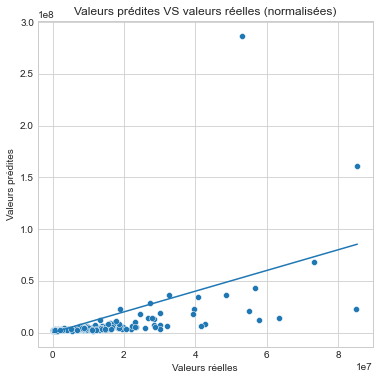

In [47]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_plot['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [48]:
MSE_without_cat = mean_squared_error(y_test_energy, pred_lr_without_cat, squared=True)
print('MSE = {:.2f}'.format(MSE_without_cat))
print('RMSE = {:.2f}'.format(MSE_without_cat**(1/2)))

R2_lr_without_cat = r2_score(y_test_energy, pred_lr_without_cat)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_without_cat))

MSE = 0.49
RMSE = 0.70
Coefficient de détermination = 0.45


[Retour à la sélection des variables](#Partie2_3)

**2. Sans les données d'énergie** <a class="anchor" id="Petit2"></a>

In [49]:
X_train_energy_without_energy = X_train_energy.drop(columns = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_energy_without_energy = X_test_energy.drop(columns = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])

np.random.seed(5)
lr_without_energy = GridSearchCV(LinearRegression(),
                                 param_grid = param_lr,            
                                 verbose = 2,
                                 cv = cv_train,
                                 scoring = score,
                                 refit = 'neg_mean_absolute_error',
                                 return_train_score = True,
                                 n_jobs = -1
                                )

lr_without_energy.fit(X_train_energy_without_energy, y_train_energy)
pred_lr_without_energy = lr_without_energy.predict(X_test_energy_without_energy)

print('Meilleurs hyperparamètres : ' + str(lr_without_energy.best_params_))

fit_time_lr_without_energy = lr_without_energy.cv_results_['mean_fit_time'].mean()
pred_time_lr_without_energy = lr_without_energy.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_without_energy))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_without_energy))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': True, 'normalize': True}
Temps écoulé pour l'entraînement = 0.01s
Temps écoulé pour la prédiction = 0.00s


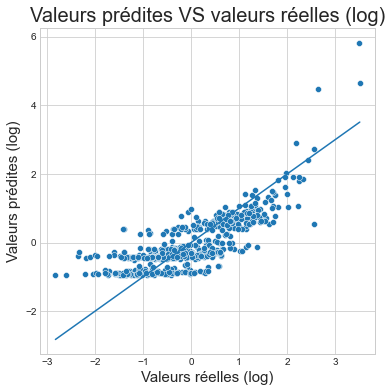

In [50]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_energy, y = pred_lr_without_energy)
plt.plot([y_test_energy.min(), y_test_energy.max()], [y_test_energy.min(), y_test_energy.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

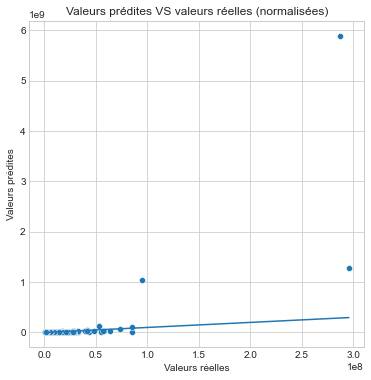

In [51]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(pred_lr_without_energy.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [52]:
outliers = pd.DataFrame(np.exp(pred_lr_without_energy))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

,prédictions
96,337.077374
5,104.421699
505,89.316612
341,18.216791
108,15.460390


In [53]:
X_test_energy_plot = X_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
y_test_energy_plot = y_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_without_energy).drop([5, 96, 505]).reset_index(drop=True)

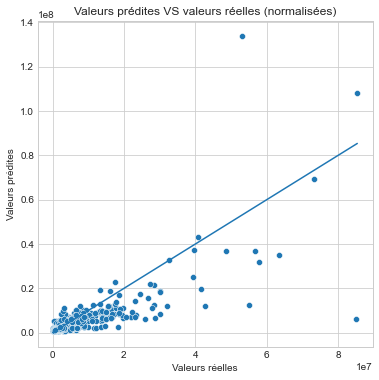

In [54]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_plot['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [55]:
MSE_without_energy = mean_squared_error(y_test_energy, pred_lr_without_energy, squared=True)
print('MSE = {:.2f}'.format(MSE_without_energy))
print('RMSE = {:.2f}'.format(MSE_without_energy**(1/2)))

R2_lr_without_energy = r2_score(y_test_energy, pred_lr_without_energy)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_without_energy))

MSE = 0.34
RMSE = 0.58
Coefficient de détermination = 0.62


[Retour à la sélection des variables](#Partie2_3)

**3. Sans les catégories de bâtiments ni les données d'énergie** <a class="anchor" id="Petit3"></a>

In [56]:
X_train_energy_without_cat_energy = X_train_energy.iloc[:, 15:-3]
X_test_energy_without_cat_energy = X_test_energy.iloc[:, 15:-3]

np.random.seed(5)
lr_without_cat_energy = GridSearchCV(LinearRegression(),
                                     param_grid = param_lr,            
                                     verbose = 2,
                                     cv = cv_train,
                                     scoring = score,
                                     refit = 'neg_mean_absolute_error',
                                     return_train_score = True,
                                     n_jobs = -1
                                    )

lr_without_cat_energy.fit(X_train_energy_without_cat_energy, y_train_energy)
pred_lr_without_cat_energy = lr_without_cat_energy.predict(X_test_energy_without_cat_energy)

print('Meilleurs hyperparamètres : ' + str(lr_without_cat_energy.best_params_))

fit_time_lr_without_cat_energy = lr_without_cat_energy.cv_results_['mean_fit_time'].mean()
pred_time_lr_without_cat_energy = lr_without_cat_energy.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_without_cat_energy))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_without_cat_energy))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': False, 'normalize': True}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


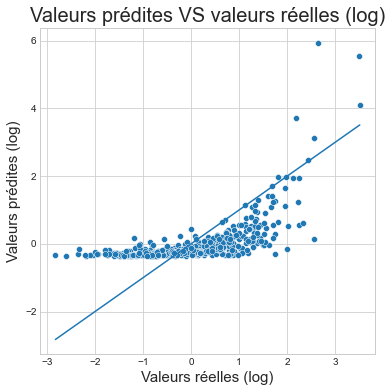

In [57]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_energy, y = pred_lr_without_cat_energy)
plt.plot([y_test_energy.min(), y_test_energy.max()], [y_test_energy.min(), y_test_energy.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

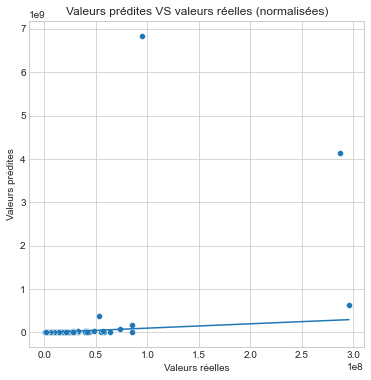

In [59]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(pred_lr_without_cat_energy.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [60]:
outliers = pd.DataFrame(np.exp(pred_lr_without_cat_energy))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

,prédictions
505,378.224019
96,257.198272
5,60.541209
341,40.611936
108,22.741415


In [61]:
X_test_energy_plot = X_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
y_test_energy_plot = y_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_without_cat_energy).drop([5, 96, 505]).reset_index(drop=True)

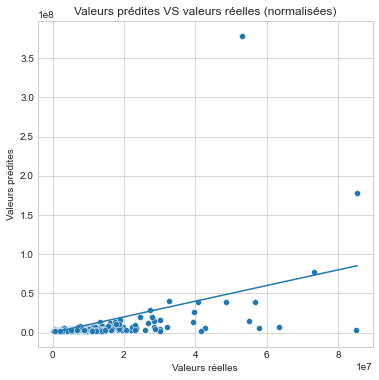

In [62]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_plot['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [63]:
MSE_without_cat_energy = mean_squared_error(y_test_energy, pred_lr_without_cat_energy, squared=True)
print('MSE = {:.2f}'.format(MSE_without_cat_energy))
print('RMSE = {:.2f}'.format(MSE_without_cat_energy**(1/2)))

R2_lr_without_cat_energy = r2_score(y_test_energy, pred_lr_without_cat_energy)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_without_cat_energy))

MSE = 0.54
RMSE = 0.74
Coefficient de détermination = 0.39


[Retour à la sélection des variables](#Partie2_3)

**4. Sans *BuildingType* ni les données d'énergie** <a class="anchor" id="Petit4"></a>

In [64]:
X_train_energy4 = X_train_energy.drop(columns = ['BuildingType_1', 'BuildingType_2', 'BuildingType_5',
                                                 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_energy4 = X_test_energy.drop(columns = ['BuildingType_1', 'BuildingType_2', 'BuildingType_5',
                                               'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])

np.random.seed(5)
lr_energy4 = GridSearchCV(LinearRegression(),
                          param_grid = param_lr, 
                          verbose = 2,
                          cv = cv_train,
                          scoring = score,
                          refit = 'neg_mean_absolute_error',
                          return_train_score = True,
                          n_jobs = -1
                         )

lr_energy4.fit(X_train_energy4, y_train_energy)
pred_lr_energy4 = lr_energy4.predict(X_test_energy4)

print('Meilleurs hyperparamètres : ' + str(lr_energy4.best_params_))

fit_time_lr_energy4 = lr_energy4.cv_results_['mean_fit_time'].mean()
pred_time_lr_energy4 = lr_energy4.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_energy4))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_energy4))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': True, 'normalize': False}
Temps écoulé pour l'entraînement = 0.01s
Temps écoulé pour la prédiction = 0.00s


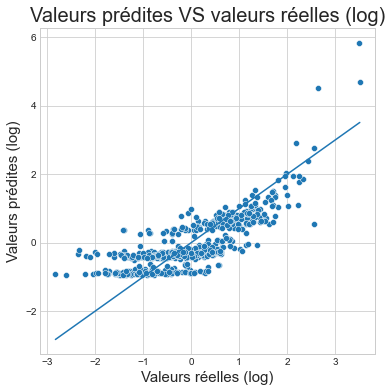

In [65]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_energy, y = pred_lr_energy4)
plt.plot([y_test_energy.min(), y_test_energy.max()], [y_test_energy.min(), y_test_energy.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

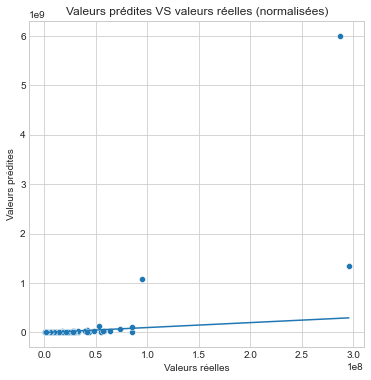

In [66]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(pred_lr_energy4.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [67]:
outliers = pd.DataFrame(np.exp(pred_lr_energy4))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

,prédictions
96,342.097293
5,107.987946
505,91.414126
341,18.187037
108,15.939294


In [68]:
X_test_energy_plot = X_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
y_test_energy_plot = y_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_energy4).drop([5, 96, 505]).reset_index(drop=True)

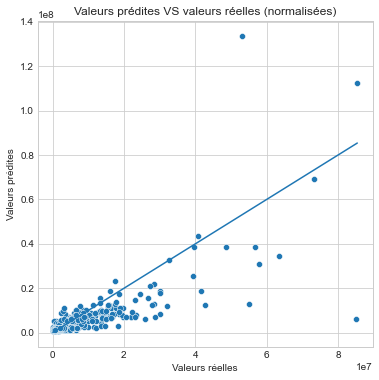

In [69]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_plot['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [70]:
MSE_energy4 = mean_squared_error(y_test_energy, pred_lr_energy4, squared=True)
print('MSE = {:.2f}'.format(MSE_energy4))
print('RMSE = {:.2f}'.format(MSE_energy4**(1/2)))

R2_lr_energy4 = r2_score(y_test_energy, pred_lr_energy4)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_energy4))

MSE = 0.34
RMSE = 0.58
Coefficient de détermination = 0.62


[Retour à la sélection des variables](#Partie2_3)

**5. Sans *PrimaryPropertyType* ni les données d'énergie** <a class="anchor" id="Petit5"></a>

In [71]:
X_train_energy5 = X_train_energy.drop(columns = ['PrimaryPropertyType_0', 'PrimaryPropertyType_1', 'PrimaryPropertyType_2',
                                                 'PrimaryPropertyType_3', 'PrimaryPropertyType_4', 'PrimaryPropertyType_5',
                                                 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_energy5 = X_test_energy.drop(columns = ['PrimaryPropertyType_0', 'PrimaryPropertyType_1', 'PrimaryPropertyType_2',
                                               'PrimaryPropertyType_3', 'PrimaryPropertyType_4', 'PrimaryPropertyType_5',
                                               'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])

np.random.seed(5)
lr_energy5 = GridSearchCV(LinearRegression(),
                          param_grid = param_lr,
                          verbose = 2,
                          cv = cv_train,
                          scoring = score,
                          refit = 'neg_mean_absolute_error',
                          return_train_score = True,
                          n_jobs = -1
                         )

lr_energy5.fit(X_train_energy5, y_train_energy)
pred_lr_energy5 = lr_energy5.predict(X_test_energy5)

print('Meilleurs hyperparamètres : ' + str(lr_energy5.best_params_))

fit_time_lr_energy5 = lr_energy5.cv_results_['mean_fit_time'].mean()
pred_time_lr_energy5 = lr_energy5.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_energy5))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_energy5))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': False, 'normalize': True}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


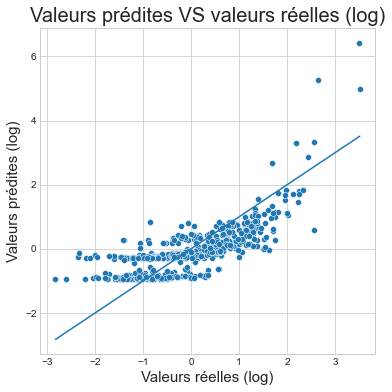

In [72]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_energy, y = pred_lr_energy5)
plt.plot([y_test_energy.min(), y_test_energy.max()], [y_test_energy.min(), y_test_energy.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

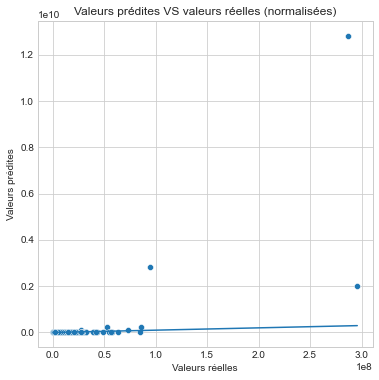

In [73]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(pred_lr_energy5.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [74]:
outliers = pd.DataFrame(np.exp(pred_lr_energy5))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

,prédictions
96,613.838249
505,191.137750
5,147.960588
108,27.824168
341,27.161721


In [75]:
X_test_energy_plot = X_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
y_test_energy_plot = y_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_energy5).drop([5, 96, 505]).reset_index(drop=True)

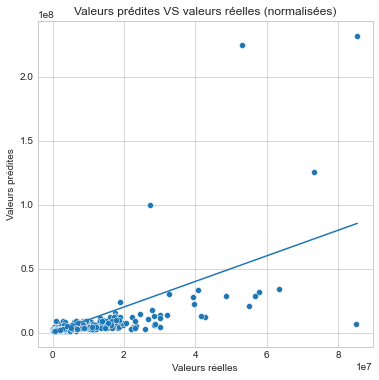

In [76]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_plot['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [77]:
MSE_energy5 = mean_squared_error(y_test_energy, pred_lr_energy5, squared=True)
print('MSE = {:.2f}'.format(MSE_energy5))
print('RMSE = {:.2f}'.format(MSE_energy5**(1/2)))

R2_lr_energy5 = r2_score(y_test_energy, pred_lr_energy5)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_energy5))

MSE = 0.40
RMSE = 0.64
Coefficient de détermination = 0.55


[Retour à la sélection des variables](#Partie2_3)

**6. Sans *LargestPropertyUseType* ni les données d'énergie** <a class="anchor" id="Petit6"></a>

In [78]:
X_train_energy6 = X_train_energy.drop(columns = ['LargestPropertyUseType_0', 'LargestPropertyUseType_1', 'LargestPropertyUseType_2',
                                                 'LargestPropertyUseType_3', 'LargestPropertyUseType_4', 'LargestPropertyUseType_5',
                                                 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_energy6 = X_test_energy.drop(columns = ['LargestPropertyUseType_0', 'LargestPropertyUseType_1', 'LargestPropertyUseType_2',
                                               'LargestPropertyUseType_3', 'LargestPropertyUseType_4', 'LargestPropertyUseType_5',
                                               'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])

np.random.seed(5)
lr_energy6 = GridSearchCV(LinearRegression(),
                          param_grid = param_lr,
                          verbose = 2,
                          cv = cv_train,
                          scoring = score,
                          refit = 'neg_mean_absolute_error',
                          return_train_score = True,
                          n_jobs = -1
                         )

lr_energy6.fit(X_train_energy6, y_train_energy)
pred_lr_energy6 = lr_energy6.predict(X_test_energy6)

print('Meilleurs hyperparamètres : ' + str(lr_energy6.best_params_))

fit_time_lr_energy6 = lr_energy6.cv_results_['mean_fit_time'].mean()
pred_time_lr_energy6 = lr_energy6.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_energy6))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_energy6))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': True, 'normalize': True}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


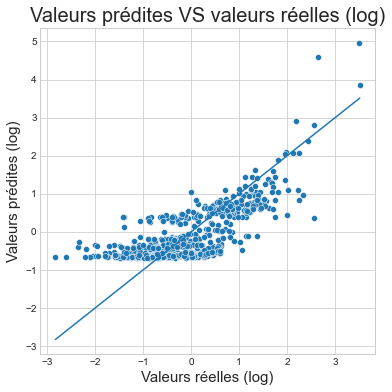

In [79]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_energy, y = pred_lr_energy6)
plt.plot([y_test_energy.min(), y_test_energy.max()], [y_test_energy.min(), y_test_energy.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

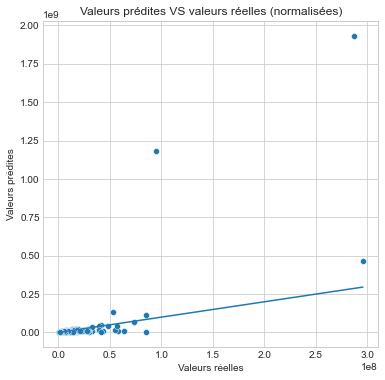

In [80]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(pred_lr_energy6.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [81]:
outliers = pd.DataFrame(np.exp(pred_lr_energy6))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

,prédictions
96,142.727540
505,97.712672
5,47.807738
341,18.431525
108,16.393337


In [82]:
X_test_energy_plot = X_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
y_test_energy_plot = y_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_energy6).drop([5, 96, 505]).reset_index(drop=True)

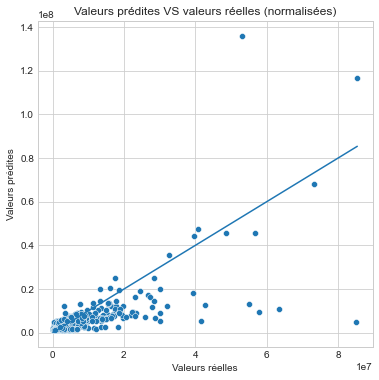

In [83]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_plot['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [84]:
MSE_energy6 = mean_squared_error(y_test_energy, pred_lr_energy6, squared=True)
print('MSE = {:.2f}'.format(MSE_energy6))
print('RMSE = {:.2f}'.format(MSE_energy6**(1/2)))

R2_lr_energy6 = r2_score(y_test_energy, pred_lr_energy6)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_energy6))

MSE = 0.39
RMSE = 0.62
Coefficient de détermination = 0.57


[Retour à la sélection des variables](#Partie2_3)

**7. Sans *BuildingType* et *PrimaryPropertyType* ni les données d'énergie** <a class="anchor" id="Petit7"></a>

In [85]:
X_train_energy7 = X_train_energy.drop(columns = ['BuildingType_1', 'BuildingType_2', 'BuildingType_5',
                                                 'PrimaryPropertyType_0', 'PrimaryPropertyType_1', 'PrimaryPropertyType_2',
                                                 'PrimaryPropertyType_3', 'PrimaryPropertyType_4', 'PrimaryPropertyType_5',
                                                 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_energy7 = X_test_energy.drop(columns = ['BuildingType_1', 'BuildingType_2', 'BuildingType_5',
                                               'PrimaryPropertyType_0', 'PrimaryPropertyType_1', 'PrimaryPropertyType_2',
                                               'PrimaryPropertyType_3', 'PrimaryPropertyType_4', 'PrimaryPropertyType_5',
                                               'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])

np.random.seed(5)
lr_energy7 = GridSearchCV(LinearRegression(),
                          param_grid = param_lr,
                          verbose = 2,
                          cv = cv_train,
                          scoring = score,
                          refit = 'neg_mean_absolute_error',
                          return_train_score = True,
                          n_jobs = -1
                         )

lr_energy7.fit(X_train_energy7, y_train_energy)
pred_lr_energy7 = lr_energy7.predict(X_test_energy7)

print('Meilleurs hyperparamètres : ' + str(lr_energy7.best_params_))

fit_time_lr_energy7 = lr_energy7.cv_results_['mean_fit_time'].mean()
pred_time_lr_energy7 = lr_energy7.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_energy7))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_energy7))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': True, 'normalize': False}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


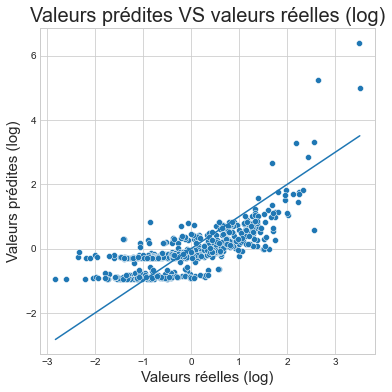

In [86]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_energy, y = pred_lr_energy7)
plt.plot([y_test_energy.min(), y_test_energy.max()], [y_test_energy.min(), y_test_energy.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

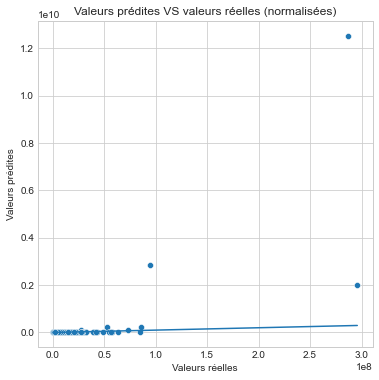

In [87]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(pred_lr_energy7.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [88]:
outliers = pd.DataFrame(np.exp(pred_lr_energy7))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

,prédictions
96,603.201515
505,192.346089
5,147.015700
108,28.027435
341,27.092711


In [89]:
X_test_energy_plot = X_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
y_test_energy_plot = y_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_energy7).drop([5, 96, 505]).reset_index(drop=True)

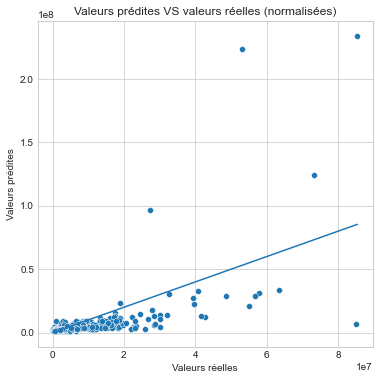

In [90]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_plot['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [91]:
MSE_energy7 = mean_squared_error(y_test_energy, pred_lr_energy7, squared=True)
print('MSE = {:.2f}'.format(MSE_energy7))
print('RMSE = {:.2f}'.format(MSE_energy7**(1/2)))

R2_lr_energy7 = r2_score(y_test_energy, pred_lr_energy7)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_energy7))

MSE = 0.40
RMSE = 0.64
Coefficient de détermination = 0.55


[Retour à la sélection des variables](#Partie2_3)

**8. Sans *BuildingType* et *LargestPropertyUseType* ni les données d'énergie** <a class="anchor" id="Petit8"></a>

In [92]:
X_train_energy8 = X_train_energy.drop(columns = ['BuildingType_1', 'BuildingType_2', 'BuildingType_5',
                                                 'LargestPropertyUseType_0', 'LargestPropertyUseType_1', 'LargestPropertyUseType_2',
                                                 'LargestPropertyUseType_3', 'LargestPropertyUseType_4', 'LargestPropertyUseType_5',
                                                 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_energy8 = X_test_energy.drop(columns = ['BuildingType_1', 'BuildingType_2', 'BuildingType_5',
                                               'LargestPropertyUseType_0', 'LargestPropertyUseType_1', 'LargestPropertyUseType_2',
                                               'LargestPropertyUseType_3', 'LargestPropertyUseType_4', 'LargestPropertyUseType_5',
                                               'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])

np.random.seed(5)
lr_energy8 = GridSearchCV(LinearRegression(),
                          param_grid = param_lr,  
                          verbose = 2,
                          cv = cv_train,
                          scoring = score,
                          refit = 'neg_mean_absolute_error',
                          return_train_score = True,
                          n_jobs = -1
                         )

lr_energy8.fit(X_train_energy8, y_train_energy)
pred_lr_energy8 = lr_energy8.predict(X_test_energy8)

print('Meilleurs hyperparamètres : ' + str(lr_energy8.best_params_))

fit_time_lr_energy8 = lr_energy8.cv_results_['mean_fit_time'].mean()
pred_time_lr_energy8 = lr_energy8.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_energy8))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_energy8))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': True, 'normalize': False}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


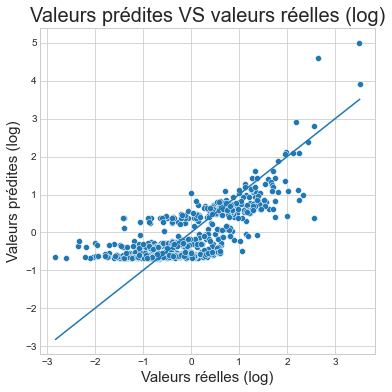

In [93]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_energy, y = pred_lr_energy8)
plt.plot([y_test_energy.min(), y_test_energy.max()], [y_test_energy.min(), y_test_energy.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

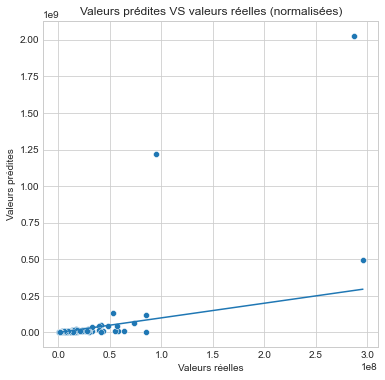

In [94]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(pred_lr_energy8.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [95]:
outliers = pd.DataFrame(np.exp(pred_lr_energy8))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

,prédictions
96,148.091882
505,100.320067
5,50.181237
341,18.467956
108,16.771159


In [96]:
X_test_energy_plot = X_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
y_test_energy_plot = y_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_energy8).drop([5, 96, 505]).reset_index(drop=True)

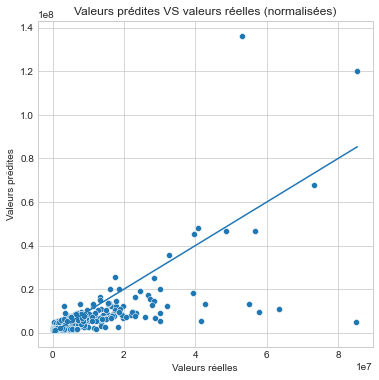

In [97]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_plot['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [98]:
MSE_energy8 = mean_squared_error(y_test_energy, pred_lr_energy8, squared=True)
print('MSE = {:.2f}'.format(MSE_energy8))
print('RMSE = {:.2f}'.format(MSE_energy8**(1/2)))

R2_lr_energy8 = r2_score(y_test_energy, pred_lr_energy8)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_energy8))

MSE = 0.39
RMSE = 0.62
Coefficient de détermination = 0.57


[Retour à la sélection des variables](#Partie2_3)

**9. Sans *PrimaryPropertyType* et *LargestPropertyUseType* ni les données d'énergie** <a class="anchor" id="Petit9"></a>

In [99]:
X_train_energy9 = X_train_energy.drop(columns = ['PrimaryPropertyType_0', 'PrimaryPropertyType_1', 'PrimaryPropertyType_2',
                                                 'PrimaryPropertyType_3', 'PrimaryPropertyType_4', 'PrimaryPropertyType_5',
                                                 'LargestPropertyUseType_0', 'LargestPropertyUseType_1', 'LargestPropertyUseType_2',
                                                 'LargestPropertyUseType_3', 'LargestPropertyUseType_4', 'LargestPropertyUseType_5',
                                                 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_energy9 = X_test_energy.drop(columns = ['PrimaryPropertyType_0', 'PrimaryPropertyType_1', 'PrimaryPropertyType_2',
                                               'PrimaryPropertyType_3', 'PrimaryPropertyType_4', 'PrimaryPropertyType_5',
                                               'LargestPropertyUseType_0', 'LargestPropertyUseType_1', 'LargestPropertyUseType_2',
                                               'LargestPropertyUseType_3', 'LargestPropertyUseType_4', 'LargestPropertyUseType_5',
                                               'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])

np.random.seed(5)
lr_energy9 = GridSearchCV(LinearRegression(),
                          param_grid = param_lr, 
                          verbose = 2,
                          cv = cv_train,
                          scoring = score,
                          refit = 'neg_mean_absolute_error',
                          return_train_score = True,
                          n_jobs = -1
                         )

lr_energy9.fit(X_train_energy9, y_train_energy)
pred_lr_energy9 = lr_energy9.predict(X_test_energy9)

print('Meilleurs hyperparamètres : ' + str(lr_energy9.best_params_))

fit_time_lr_energy9 = lr_energy9.cv_results_['mean_fit_time'].mean()
pred_time_lr_energy9 = lr_energy9.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_energy9))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_energy9))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': False, 'normalize': True}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


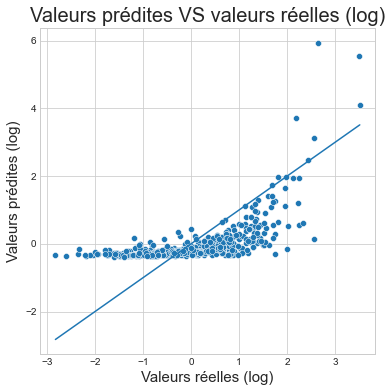

In [100]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_energy, y = pred_lr_energy9)
plt.plot([y_test_energy.min(), y_test_energy.max()], [y_test_energy.min(), y_test_energy.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

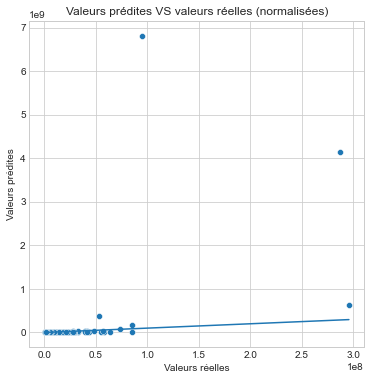

In [101]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(pred_lr_energy9.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [102]:
outliers = pd.DataFrame(np.exp(pred_lr_energy9))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

,prédictions
505,377.126283
96,257.361188
5,59.987823
341,40.764031
108,22.603370


In [103]:
X_test_energy_plot = X_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
y_test_energy_plot = y_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_energy9).drop([5, 96, 505]).reset_index(drop=True)

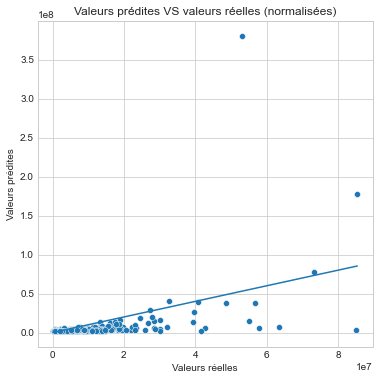

In [105]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_plot['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [106]:
MSE_energy9 = mean_squared_error(y_test_energy, pred_lr_energy9, squared=True)
print('MSE = {:.2f}'.format(MSE_energy9))
print('RMSE = {:.2f}'.format(MSE_energy9**(1/2)))

R2_lr_energy9 = r2_score(y_test_energy, pred_lr_energy9)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_energy9))

MSE = 0.54
RMSE = 0.74
Coefficient de détermination = 0.39


[Retour à la sélection des variables](#Partie2_3)

**10. Seulement avec les données d'énergie** <a class="anchor" id="Petit10"></a>

In [107]:
X_train_only_energy = X_train_energy[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']]
X_test_only_energy = X_test_energy[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']]

np.random.seed(5)
lr_only_energy = GridSearchCV(LinearRegression(),
                              param_grid = param_lr,            
                              verbose = 2,
                              cv = cv_train,
                              scoring = score,
                              refit = 'neg_mean_absolute_error',
                              return_train_score = True,
                              n_jobs = -1
                             )

lr_only_energy.fit(X_train_only_energy, y_train_energy)
pred_lr_only_energy = lr_only_energy.predict(X_test_only_energy)

print('Meilleurs hyperparamètres : ' + str(lr_only_energy.best_params_))

fit_time_lr_only_energy = lr_only_energy.cv_results_['mean_fit_time'].mean()
pred_time_lr_only_energy = lr_only_energy.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_only_energy))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_only_energy))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': False, 'normalize': True}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


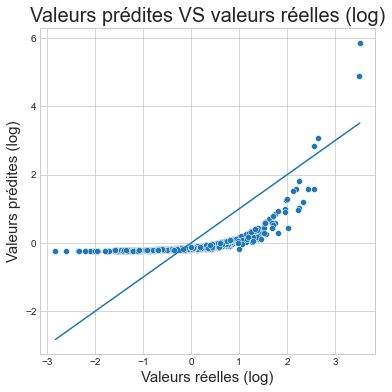

In [108]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_energy, y = pred_lr_only_energy)
plt.plot([y_test_energy.min(), y_test_energy.max()], [y_test_energy.min(), y_test_energy.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

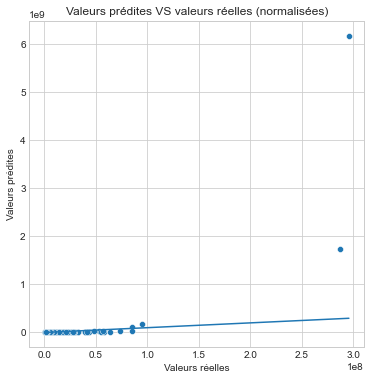

In [109]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(pred_lr_only_energy.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [110]:
outliers = pd.DataFrame(np.exp(pred_lr_only_energy))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

,prédictions
5,349.679939
96,131.939622
505,21.837086
87,17.104544
543,6.182684


In [111]:
X_test_energy_plot = X_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
y_test_energy_plot = y_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_without_cat).drop([5, 96, 505]).reset_index(drop=True)

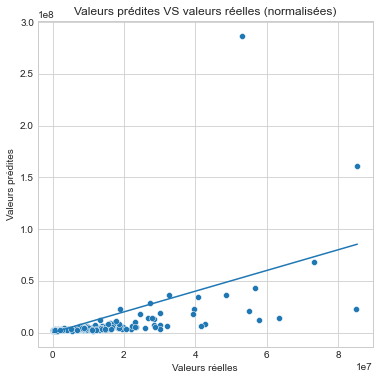

In [112]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_plot['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [113]:
MSE_only_energy = mean_squared_error(y_test_energy, pred_lr_only_energy, squared=True)
print('MSE = {:.2f}'.format(MSE_only_energy))
print('RMSE = {:.2f}'.format(MSE_only_energy**(1/2)))

R2_lr_only_energy = r2_score(y_test_energy, pred_lr_only_energy)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_only_energy))

MSE = 0.55
RMSE = 0.74
Coefficient de détermination = 0.39


[Retour à la sélection des variables](#Partie2_3)

**Comparaison des modèles** <a class="anchor" id="Comp"></a>

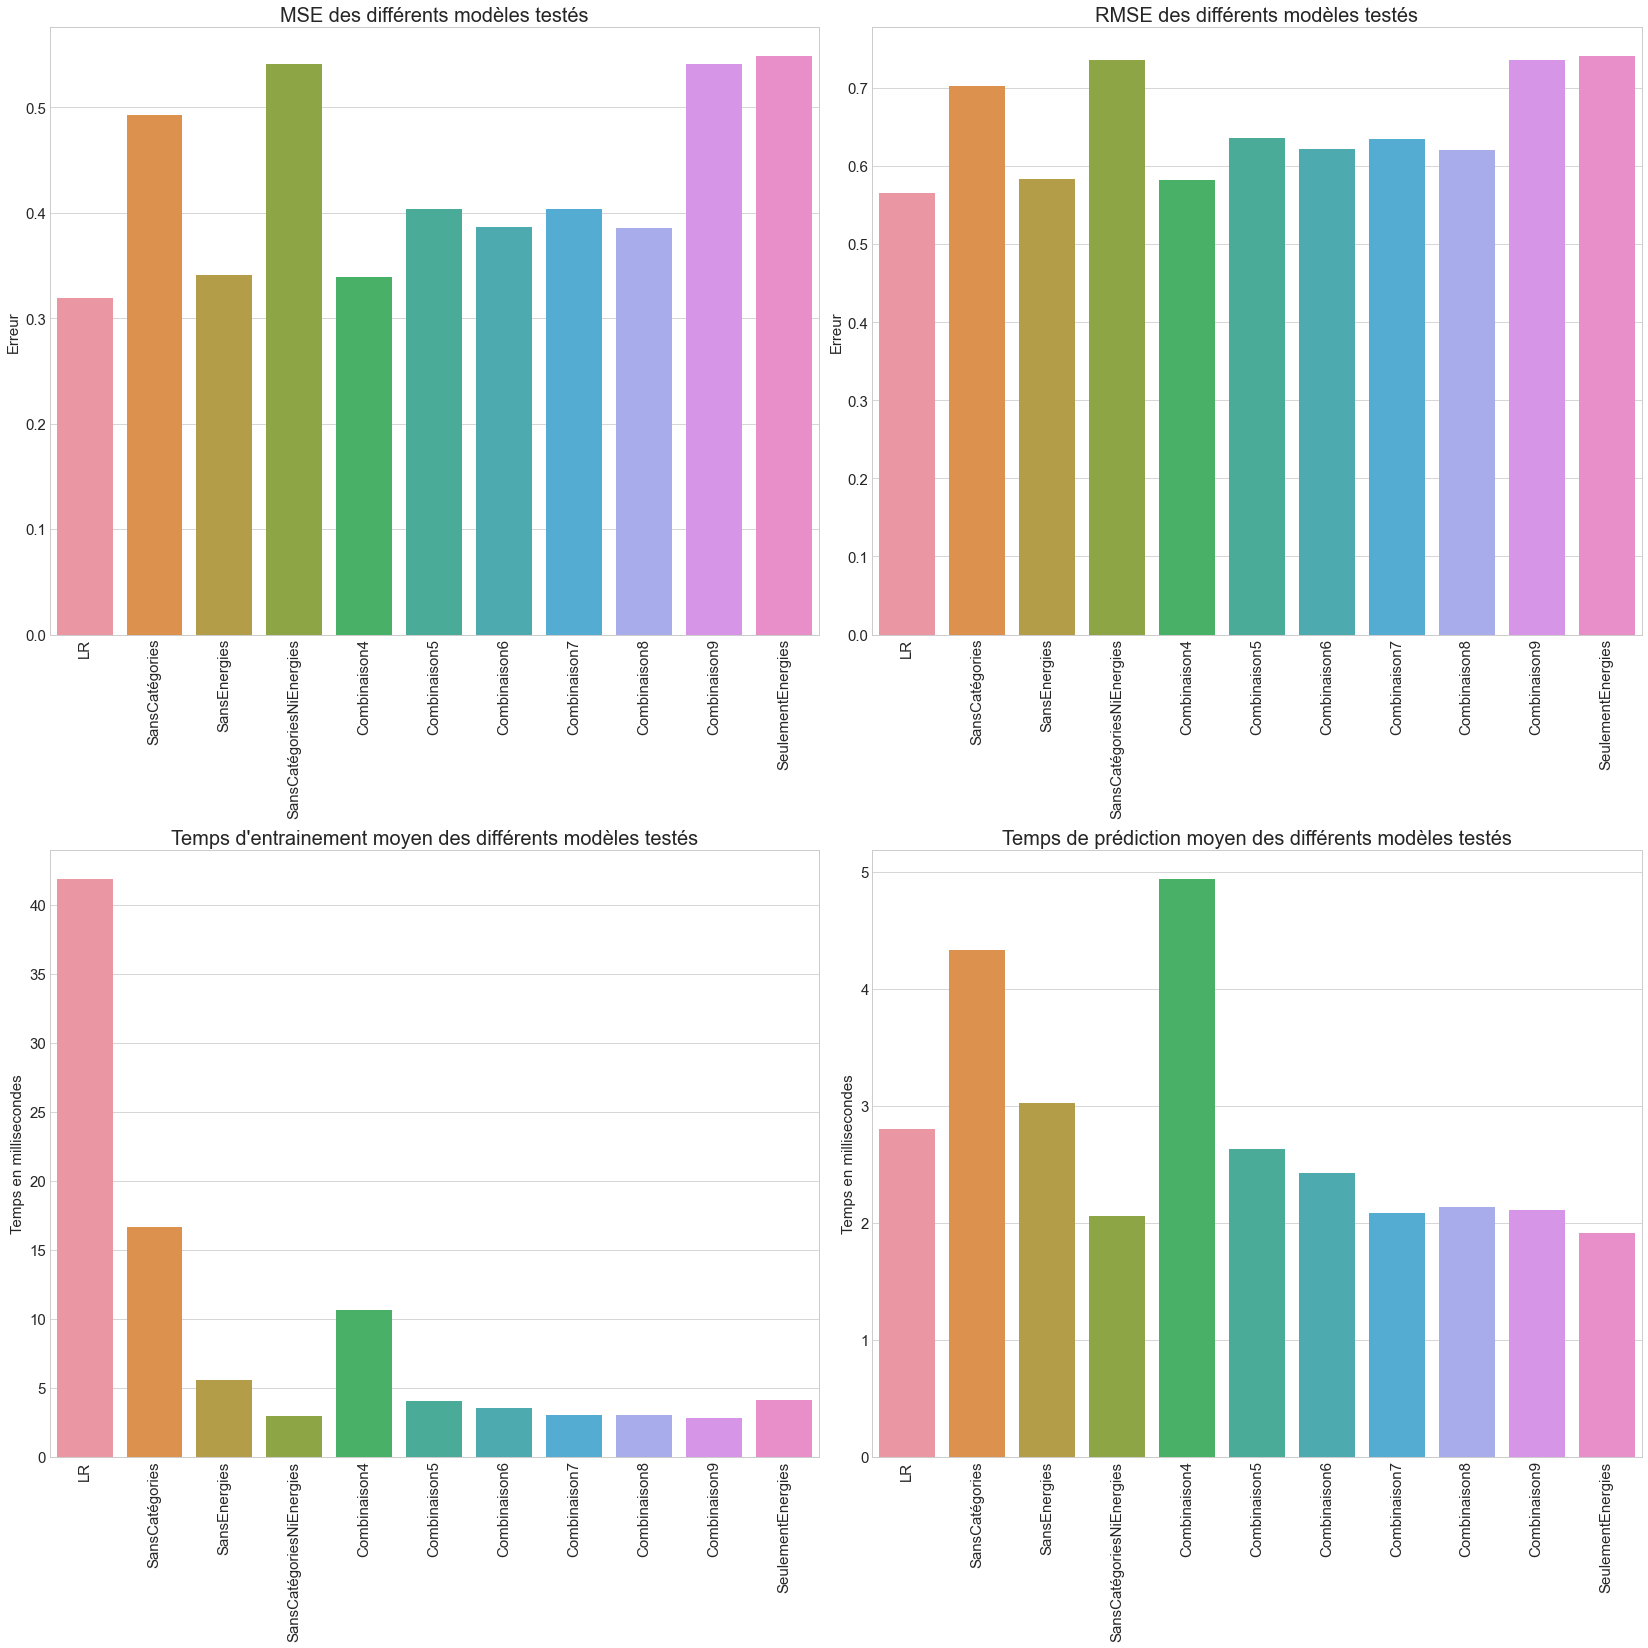

In [114]:
fig = plt.figure(figsize = (23, 23))
listeModeles = ['LR', 'SansCatégories', 'SansEnergies', 'SansCatégoriesNiEnergies', 'Combinaison4', 'Combinaison5',
                'Combinaison6', 'Combinaison7', 'Combinaison8', 'Combinaison9', 'SeulementEnergies']

listeMSE = [baseline_error, MSE_without_cat, MSE_without_energy, MSE_without_cat_energy, MSE_energy4, MSE_energy5, MSE_energy6,
            MSE_energy7, MSE_energy8, MSE_energy9, MSE_only_energy]
listeRMSE = [elt**(1/2) for elt in listeMSE]
listeFitTime_s = [fit_time_lr, fit_time_lr_without_cat, fit_time_lr_without_energy, fit_time_lr_without_cat_energy,
                  fit_time_lr_energy4,  fit_time_lr_energy5, fit_time_lr_energy6, fit_time_lr_energy7, fit_time_lr_energy8,
                  fit_time_lr_energy9, fit_time_lr_only_energy]
listeFitTime = [1000*elt for elt in listeFitTime_s]
listePredTime_s = [pred_time_lr, pred_time_lr_without_cat, pred_time_lr_without_energy, pred_time_lr_without_cat_energy,
                   pred_time_lr_energy4, pred_time_lr_energy5, pred_time_lr_energy6, pred_time_lr_energy7, pred_time_lr_energy8,
                   pred_time_lr_energy9, pred_time_lr_only_energy]
listePredTime = [1000*elt for elt in listePredTime_s]

plt.subplot(2,2,1)
sns.barplot(x = listeModeles, y = listeMSE)
plt.title('MSE des différents modèles testés', fontsize = 20)
plt.ylabel('Erreur', fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,2)
sns.barplot(x = listeModeles, y = listeRMSE)
plt.title('RMSE des différents modèles testés', fontsize = 20)
plt.ylabel('Erreur', fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,3)
sns.barplot(x = listeModeles, y = listeFitTime)
plt.title('Temps d\'entrainement moyen des différents modèles testés', fontsize = 20)
plt.ylabel('Temps en millisecondes', fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,4)
sns.barplot(x = listeModeles, y = listePredTime)
plt.title('Temps de prédiction moyen des différents modèles testés', fontsize = 20)
plt.ylabel('Temps en millisecondes', fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.tick_params(axis='both', which='major', labelsize=15)

fig.tight_layout()
plt.show()

In [115]:
print(listeRMSE)

[0.5650660786204048, 0.7020391509478291, 0.5837595481922955, 0.735768953808459, 0.582197194627648, 0.6353973581802949, 0.6217171872622876, 0.6350759886288018, 0.6208955879236174, 0.7359327205028616, 0.7405572154160565]


In [116]:
for i in range(len(listeMSE)) :
    print(str(listeModeles[i]) + ' : MSE = ' + str(listeMSE[i]))

LR : MSE = 0.31929967320744157
SansCatégories : MSE = 0.4928589694635488
SansEnergies : MSE = 0.3407752101056729
SansCatégoriesNiEnergies : MSE = 0.5413559533883943
Combinaison4 : MSE = 0.33895357343230337
Combinaison5 : MSE = 0.403729802782498
Combinaison6 : MSE = 0.38653226093733045
Combinaison7 : MSE = 0.40332151133285
Combinaison8 : MSE = 0.38551133110301455
Combinaison9 : MSE = 0.541596969106743
SeulementEnergies : MSE = 0.5484249893047835


La combinaison des variables ayant la MSE la plus faible est la régression linaire baseline (faite avec toutes les variables). Cependant, on ne peut pas l'utiliser à cause du Data Leakage. Nous choississons donc d'utiliser la combinaison 4 : Sans ```BuildingType``` ni les données d'énergie.

In [117]:
X_train_energy = X_train_energy.drop(columns = ['BuildingType_1', 'BuildingType_2', 'BuildingType_5',
                                                'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_energy = X_test_energy.drop(columns = ['BuildingType_1', 'BuildingType_2', 'BuildingType_5',
                                              'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])

[Retour au sommaire](#Sommaire)
### Régression Ridge <a class="anchor" id="Partie2_4"></a>
#### Mise en place du modèle

In [119]:
from sklearn.linear_model import Ridge

np.random.seed(5)
n_alphas = 200
param_ridge = {'fit_intercept' : [True, False],
               'normalize': [True, False],
               'alpha': np.logspace(-5, 5, n_alphas)
              }

ridge = GridSearchCV(Ridge(),
                     param_grid = param_ridge,            
                     verbose = 2,
                     cv = cv_train,
                     scoring = score,
                     refit = 'neg_mean_absolute_error',
                     return_train_score = True,
                     n_jobs = -1
                    )

ridge.fit(X_train_energy, y_train_energy)
pred_ridge = ridge.predict(X_test_energy)

print('Meilleurs hyperparamètres : ' + str(ridge.best_params_))

fit_time_ridge = ridge.cv_results_['mean_fit_time'].mean()
pred_time_ridge = ridge.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}ms'.format(1000*fit_time_ridge))
print('Temps écoulé pour la prédiction = {:.2f}ms'.format(1000*pred_time_ridge))

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
Meilleurs hyperparamètres : {'alpha': 0.026126752255633292, 'fit_intercept': True, 'normalize': True}
Temps écoulé pour l'entraînement = 6.33ms
Temps écoulé pour la prédiction = 4.48ms


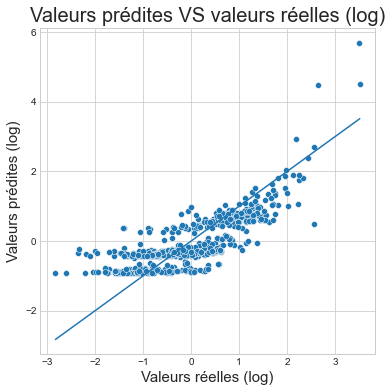

In [120]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_energy, y = pred_ridge)
plt.plot([y_test_energy.min(), y_test_energy.max()], [y_test_energy.min(), y_test_energy.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

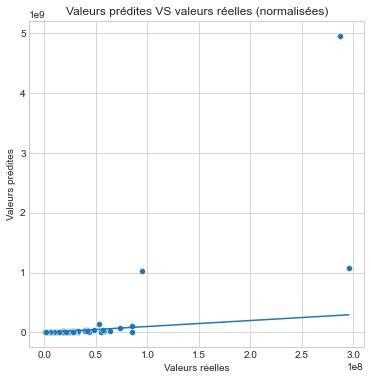

In [122]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(pred_ridge.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [123]:
outliers = pd.DataFrame(np.exp(pred_ridge))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

,prédictions
96,295.183230
5,90.592065
505,88.074941
341,18.694845
108,14.962026


In [124]:
X_test_energy_plot = X_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
y_test_energy_plot = y_test_energy_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_ridge).drop([5, 96, 505]).reset_index(drop=True)

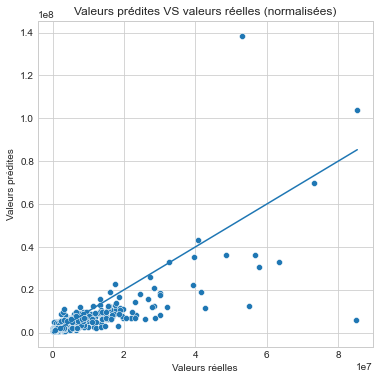

In [126]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_plot['SiteEnergyUse(kBtu)'],
                y = np.exp(std_scale_y.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_plot['SiteEnergyUse(kBtu)'].min(), X_test_energy_plot['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [127]:
MSE_ridge = mean_squared_error(y_test_energy, pred_ridge, squared=True)
print('MSE = {:.2f}'.format(MSE_ridge))
print('RMSE = {:.2f}'.format(MSE_ridge**(1/2)))

R2_ridge = r2_score(y_test_energy, pred_ridge)
print('Coefficient de détermination = {:.2f}'.format(R2_ridge))

MSE = 0.34
RMSE = 0.58
Coefficient de détermination = 0.62


[Retour au sommaire](#Sommaire)
### Forêt aléatoire <a class="anchor" id="Partie2_5"></a>

In [130]:
from sklearn.ensemble import RandomForestRegressor

np.random.seed(5)
param_rfr = { 
    'n_estimators': [100, 200, 300, 500, 800, 1000, 1200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5, 10, 15, 20, 25, 30, 35, None],
    'bootstrap' : [True, False]
}

rfr = GridSearchCV(RandomForestRegressor(),
                   param_grid = param_rfr,
                   verbose = 3,
                   cv = cv_train,
                   scoring = score,
                   refit = 'neg_mean_absolute_error',
                   return_train_score = True,
                   n_jobs = -1
                  )

In [131]:
rfr.fit(X_train_energy, y_train_energy)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 15, 20, 25, 30, 35, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 500, 800, 1000, 1200]},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=3)

In [132]:
pred_rfr = rfr.predict(X_test_energy)

In [133]:
print('Meilleurs hyperparamètres : ' + str(rfr.best_params_))

fit_time_rfr = rfr.cv_results_['mean_fit_time'].mean()
pred_time_rfr = rfr.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_rfr))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_rfr))

Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 500}
Temps écoulé pour l'entraînement = 4.58s
Temps écoulé pour la prédiction = 0.17s


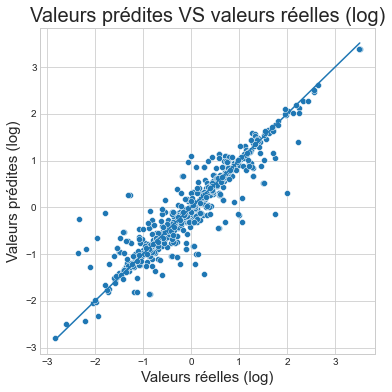

In [134]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_energy, y = pred_rfr)
plt.plot([y_test_energy.min(), y_test_energy.max()], [y_test_energy.min(), y_test_energy.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

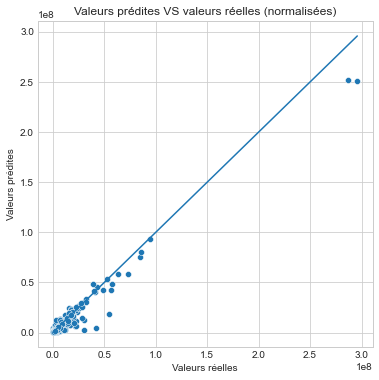

In [136]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_energy_['SiteEnergyUse(kBtu)'], y = np.exp(std_scale_y.inverse_transform(pred_rfr.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()],
         [X_test_energy_['SiteEnergyUse(kBtu)'].min(), X_test_energy_['SiteEnergyUse(kBtu)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [137]:
MSE_rfr = mean_squared_error(y_test_energy, pred_rfr, squared=True)
print('MSE = {:.2f}'.format(MSE_rfr))
print('RMSE = {:.2f}'.format(MSE_rfr**(1/2)))

R2_rfr = r2_score(y_test_energy, pred_rfr)
print('Coefficient de détermination = {:.2f}'.format(R2_rfr))

MSE = 0.13
RMSE = 0.36
Coefficient de détermination = 0.85


[Retour au sommaire](#Sommaire)
### Comparaison des modèles <a class="anchor" id="Partie2_6"></a>

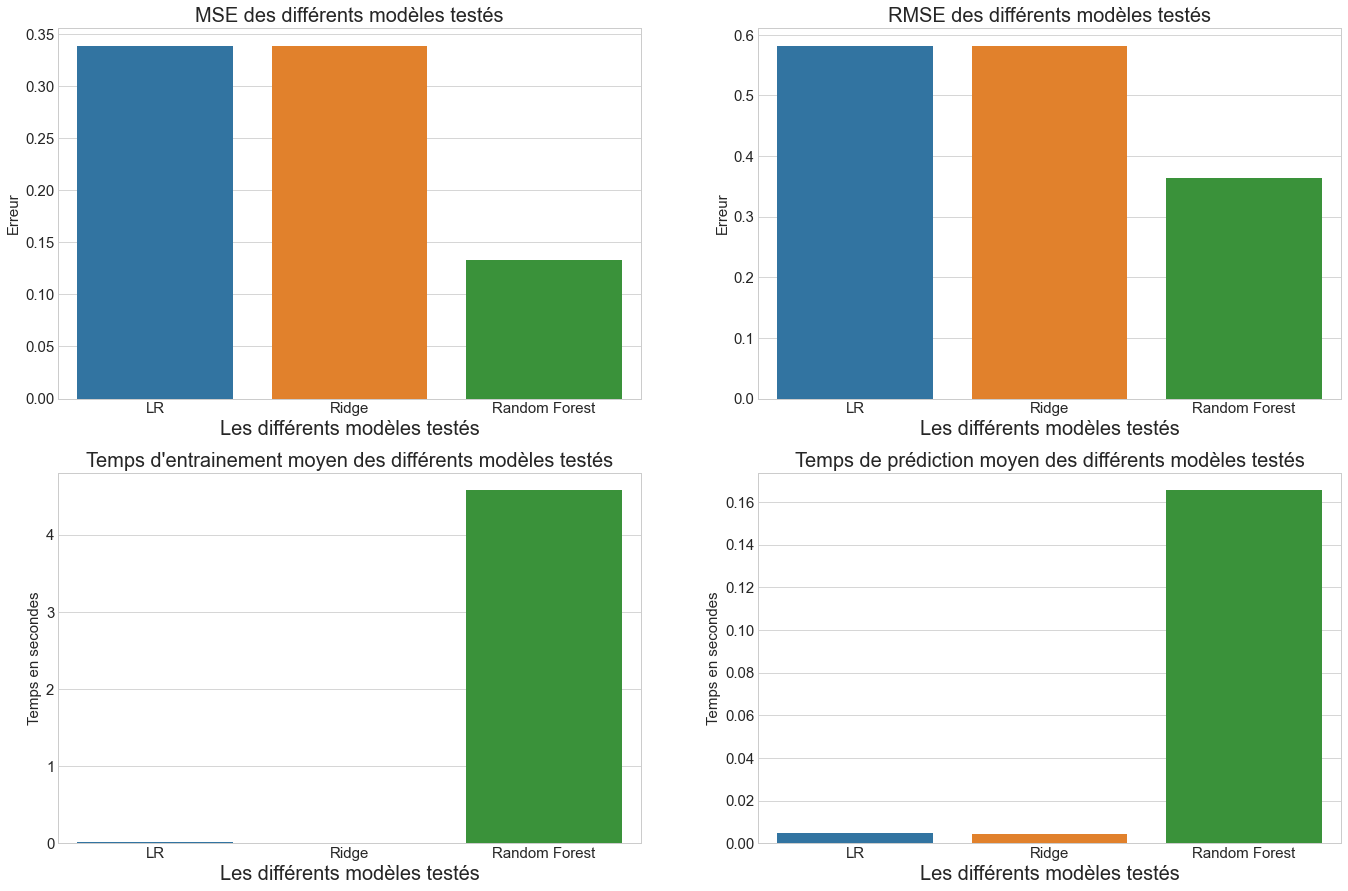

In [138]:
fig = plt.figure(figsize = (23, 15))
listeModeles = ['LR', 'Ridge', 'Random Forest']

listeMSE = [MSE_energy4, MSE_ridge, MSE_rfr]
listeRMSE = [elt**(1/2) for elt in listeMSE]
listeFitTime = [fit_time_lr_energy4, fit_time_ridge, fit_time_rfr]
listePredTime = [pred_time_lr_energy4, pred_time_ridge, pred_time_rfr]

plt.subplot(2,2,1)
sns.barplot(x = listeModeles, y = listeMSE)
plt.title('MSE des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,2)
sns.barplot(x = listeModeles, y = listeRMSE)
plt.title('RMSE des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,3)
sns.barplot(x = listeModeles, y = listeFitTime)
plt.title('Temps d\'entrainement moyen des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Temps en secondes', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,4)
sns.barplot(x = listeModeles, y = listePredTime)
plt.title('Temps de prédiction moyen des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Temps en secondes', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

Bien que les temps d'entraînement et de prédiction de la *RandomForest* soient bien plus long que ceux des autres modèles. Les performances en sont d'autant meilleures. Le meilleur modèle pour nos données est donc la forêt aléatoire.

[Retour au sommaire](#Sommaire)
## Modèles pour les émissions de CO2 <a class="anchor" id="Partie3"></a>
### Préparation des données <a class="anchor" id="Partie3_1"></a>
#### Séparation en données d'entraînement et de test

In [139]:
X_CO2 = df_Elec_.iloc[:,0:-2]
X_CO2 = X_CO2.drop(columns = ['SiteEnergyUse(kBtu)'])
y_CO2 = df_Elec_.iloc[:,-1]

X_train_CO2_, X_test_CO2_, y_train_CO2_, y_test_CO2_ = train_test_split(X_CO2, y_CO2, test_size=0.3,
                                                                                    random_state=42)

X_train_CO2_ = X_train_CO2_.reset_index(drop=True)
X_test_CO2_ = X_test_CO2_.reset_index(drop=True)
y_train_CO2_ = y_train_CO2_.reset_index(drop=True)
y_test_CO2_ = y_test_CO2_.reset_index(drop=True)

In [140]:
print(X_train_CO2_.shape)
print(X_test_CO2_.shape)
print(y_train_CO2_.shape)
print(y_test_CO2_.shape)

(1505, 26)
(645, 26)
(1505,)
(645,)


In [141]:
X_train_CO2_.iloc[:, 14:].head()

,LargestPropertyUseType_5,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ENERGYSTARScore,TotalGHGEmissions(Tons)
0,0.0,1.0,7.0,277486,80283,197203,178625.0,0.0,12729856.0,0.0,63.0,88.74
1,0.0,1.0,3.0,103000,0,103000,103000.0,0.0,2338435.0,2515995.0,42.0,149.93
2,0.0,1.0,2.0,24152,0,24152,24152.0,0.0,50897.0,0.0,100.0,0.35
3,0.0,1.0,15.0,115775,31535,84240,150000.0,0.0,2892548.0,0.0,93.0,20.16
4,0.0,1.0,2.0,23500,0,23500,23500.0,0.0,1170650.0,470945.0,28.0,33.17


In [142]:
y_train_CO2_.head()

0    4.485711
1    5.010169
2   -1.049822
3    3.003700
4    3.501646
Name: TotalGHGEmissions(log), dtype: float64

#### Standardisation des variables numériques
Nous allons standardiser toutes nos variables numériques de ```X_train_CO2_``` c'est à dire toutes les variables sauf ```LargestPropertyUseType``` qui est une variable catégorielle.

In [143]:
std_scale_X_CO2 = preprocessing.StandardScaler().fit(X_train_CO2_.iloc[:, 15:-2])
X_train_std2 = std_scale_X_CO2.transform(X_train_CO2_.iloc[:, 15:-2])
X_test_std2 = std_scale_X_CO2.transform(X_test_CO2_.iloc[:, 15:-2])

std_scale_y_CO2 = preprocessing.StandardScaler().fit(np.array(y_train_CO2_).reshape(-1, 1))
y_train_std2 = std_scale_y_CO2.transform(np.array(y_train_CO2_).reshape(-1, 1))
y_test_std2 = std_scale_y_CO2.transform(np.array(y_test_CO2_).reshape(-1, 1))

In [145]:
X_train_CO2 = X_train_CO2_.iloc[:, :15].join(pd.DataFrame(X_train_std2))
X_train_CO2.columns = X_train_CO2_.columns[:-2]
X_test_CO2 = X_test_CO2_.iloc[:, :15].join(pd.DataFrame(X_test_std2))
X_test_CO2.columns = X_train_CO2_.columns[:-2]

In [146]:
y_data_train2 = pd.DataFrame(y_train_std2)
y_data_train2.columns = ['TotalGHGEmissions(log)']
y_train_CO2 = y_data_train2['TotalGHGEmissions(log)']

y_data_test2 = pd.DataFrame(y_test_std2)
y_data_test2.columns = ['TotalGHGEmissions(log)']
y_test_CO2 = y_data_test2['TotalGHGEmissions(log)']

In [147]:
X_train_CO2.head()

,BuildingType_1,BuildingType_2,BuildingType_5,PrimaryPropertyType_0,PrimaryPropertyType_1,PrimaryPropertyType_2,PrimaryPropertyType_3,PrimaryPropertyType_4,PrimaryPropertyType_5,LargestPropertyUseType_0,...,LargestPropertyUseType_5,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.041924,0.241847,0.683601,1.313040,0.448974,0.411667,-0.088979,0.424304,-0.190467
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,-0.041924,-0.241365,-0.126173,-0.333263,-0.058963,-0.027697,-0.088979,-0.232315,0.053322
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.041924,-0.362168,-0.492100,-0.333263,-0.484107,-0.485786,-0.088979,-0.376861,-0.190467
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.041924,1.208271,-0.066885,0.313401,-0.160116,0.245363,-0.088979,-0.197302,-0.190467
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.041924,-0.362168,-0.495126,-0.333263,-0.487622,-0.489574,-0.088979,-0.306106,-0.144835


[Retour au sommaire](#Sommaire)

### Régression Linéaire (Baseline) <a class="anchor" id="Partie3_2"></a>

In [148]:
np.random.seed(5)
lr_CO2 = GridSearchCV(LinearRegression(),
                      param_grid = param_lr,
                      verbose = 2,
                      cv = cv_train,
                      scoring = score,
                      refit = 'neg_mean_absolute_error',
                      return_train_score = True,
                      n_jobs = -1
                     )

lr_CO2.fit(X_train_CO2, y_train_CO2)
pred_lr_CO2 = lr_CO2.predict(X_test_CO2)

print('Meilleurs hyperparamètres : ' + str(lr_CO2.best_params_))

fit_time_lr_CO2 = lr_CO2.cv_results_['mean_fit_time'].mean()
pred_time_lr_CO2 = lr_CO2.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_CO2))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_CO2))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': True, 'normalize': False}
Temps écoulé pour l'entraînement = 0.08s
Temps écoulé pour la prédiction = 0.00s


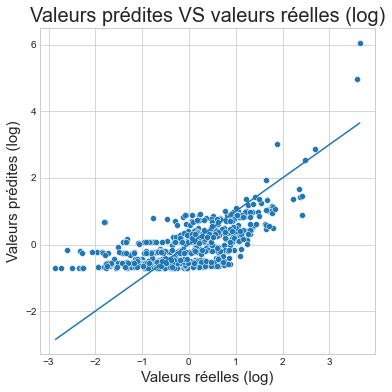

In [149]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_CO2, y = pred_lr_CO2)
plt.plot([y_test_CO2.min(), y_test_CO2.max()], [y_test_CO2.min(), y_test_CO2.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

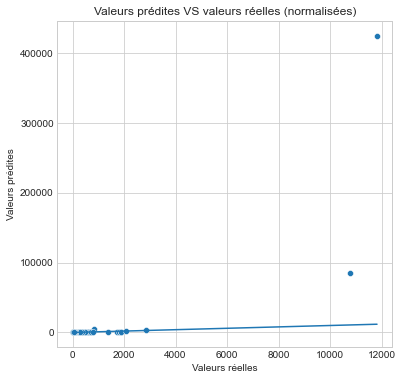

In [151]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(pred_lr_CO2.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [153]:
outliers = pd.DataFrame(np.exp(std_scale_y_CO2.inverse_transform(pred_lr_CO2.reshape(-1, 1))).reshape(-1, ))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

,prédictions
96,424820.025304
5,85457.353569
505,4628.720043
108,3754.619066
614,2235.184749


In [154]:
X_test_CO2_plot = X_test_CO2_.drop([5, 96]).reset_index(drop=True)
y_test_CO2_plot = y_test_CO2_.drop([5, 96]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_CO2).drop([5, 96]).reset_index(drop=True)

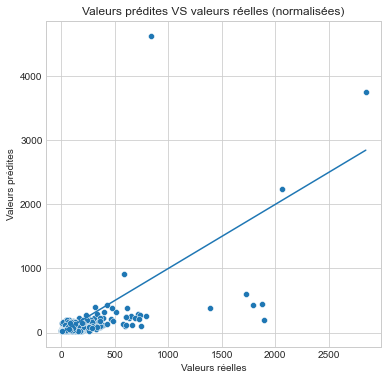

In [155]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_plot['TotalGHGEmissions(Tons)'],
                y = np.exp(std_scale_y_CO2.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [156]:
# On enregistre l'erreur de notre régression comme une baseline
baseline_CO2_error = mean_squared_error(y_test_CO2, pred_lr_CO2, squared=True)
print('MSE = {:.2f}'.format(baseline_CO2_error))
print('RMSE = {:.2f}'.format(baseline_CO2_error**(1/2)))

R2_lr_CO2 = r2_score(y_test_CO2, pred_lr_CO2)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_CO2))

MSE = 0.49
RMSE = 0.70
Coefficient de détermination = 0.45


[Retour au sommaire](#Sommaire)

### Sélection des variables  <a class="anchor" id="Partie3_3"></a>
Essayons d'entraîner une régression linéaire avec des combinaisons de variables différentes.

**1. Sans les catégories de bâtiments**

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': False, 'normalize': True}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


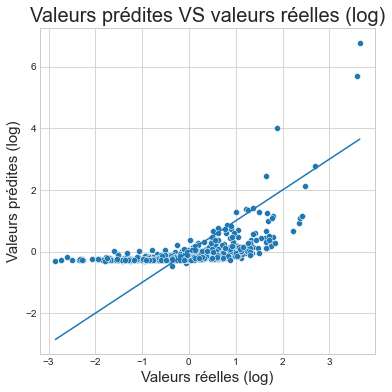

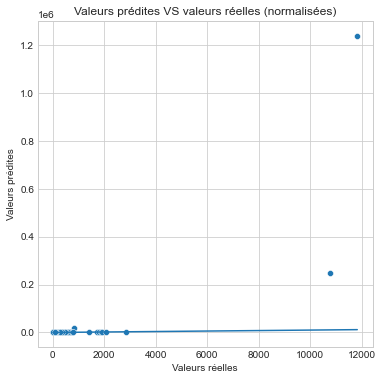

,prédictions
96,873.839520
5,298.110126
505,56.120944
108,15.914204
341,11.691189


In [159]:
X_train_CO2_without_cat = X_train_CO2.iloc[:, 15:]
X_test_CO2_without_cat = X_test_CO2.iloc[:, 15:]
np.random.seed(5)
lr_CO2_without_cat = GridSearchCV(LinearRegression(),
                                  param_grid = param_lr,
                                  verbose = 2,
                                  cv = cv_train,
                                  scoring = score,
                                  refit = 'neg_mean_absolute_error',
                                  return_train_score = True,
                                  n_jobs = -1
                                 )
lr_CO2_without_cat.fit(X_train_CO2_without_cat, y_train_CO2)
pred_lr_CO2_without_cat = lr_CO2_without_cat.predict(X_test_CO2_without_cat)
print('Meilleurs hyperparamètres : ' + str(lr_CO2_without_cat.best_params_))
fit_time_lr_CO2_without_cat = lr_CO2_without_cat.cv_results_['mean_fit_time'].mean()
pred_time_lr_CO2_without_cat = lr_CO2_without_cat.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_CO2_without_cat))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_CO2_without_cat))


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_CO2, y = pred_lr_CO2_without_cat)
plt.plot([y_test_CO2.min(), y_test_CO2.max()], [y_test_CO2.min(), y_test_CO2.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_['TotalGHGEmissions(Tons)'],
                y = np.exp(std_scale_y_CO2.inverse_transform(pred_lr_CO2_without_cat.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


outliers = pd.DataFrame(np.exp(pred_lr_CO2_without_cat))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

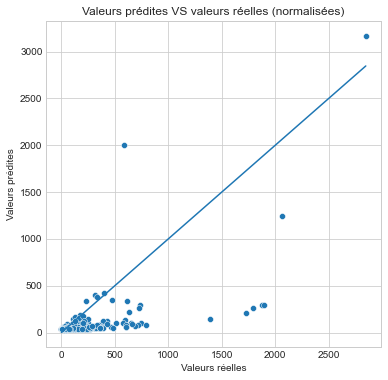

MSE = 0.63
RMSE = 0.79
Coefficient de détermination = 0.30


In [161]:
X_test_CO2_plot = X_test_CO2_.drop([5, 96, 505]).reset_index(drop=True)
y_test_CO2_plot = y_test_CO2_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_CO2_without_cat).drop([5, 96, 505]).reset_index(drop=True)


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_plot['TotalGHGEmissions(Tons)'],
y = np.exp(std_scale_y_CO2.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


MSE_CO2_without_cat = mean_squared_error(y_test_CO2, pred_lr_CO2_without_cat, squared=True)
print('MSE = {:.2f}'.format(MSE_CO2_without_cat))
print('RMSE = {:.2f}'.format(MSE_CO2_without_cat**(1/2)))
R2_lr_CO2_without_cat = r2_score(y_test_CO2, pred_lr_CO2_without_cat)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_CO2_without_cat))

**2. Sans les données d'énergie**

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': True, 'normalize': False}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


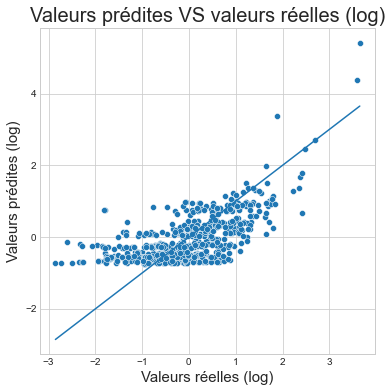

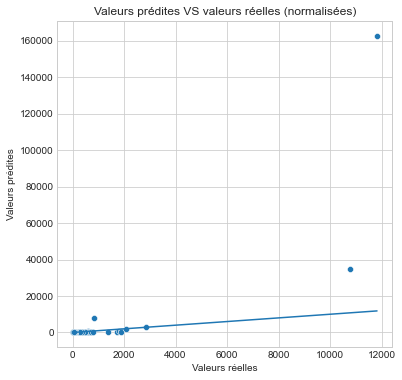

,prédictions
96,223.654675
5,79.410547
505,29.115382
108,15.093467
614,11.524541


In [163]:
X_train_CO2_without_energy = X_train_CO2.drop(columns = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_CO2_without_energy = X_test_CO2.drop(columns = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
np.random.seed(5)
lr_CO2_without_energy = GridSearchCV(LinearRegression(),
                                     param_grid = param_lr,
                                     verbose = 2,
                                     cv = cv_train,
                                     scoring = score,
                                     refit = 'neg_mean_absolute_error',
                                     return_train_score = True,
                                     n_jobs = -1
                                    )
lr_CO2_without_energy.fit(X_train_CO2_without_energy, y_train_CO2)
pred_lr_CO2_without_energy = lr_CO2_without_energy.predict(X_test_CO2_without_energy)
print('Meilleurs hyperparamètres : ' + str(lr_CO2_without_energy.best_params_))
fit_time_lr_CO2_without_energy = lr_CO2_without_energy.cv_results_['mean_fit_time'].mean()
pred_time_lr_CO2_without_energy = lr_CO2_without_energy.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_CO2_without_energy))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_CO2_without_energy))

fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_CO2, y = pred_lr_CO2_without_energy)
plt.plot([y_test_CO2.min(), y_test_CO2.max()], [y_test_CO2.min(), y_test_CO2.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_['TotalGHGEmissions(Tons)'],
                y = np.exp(std_scale_y_CO2.inverse_transform(pred_lr_CO2_without_energy.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


outliers = pd.DataFrame(np.exp(pred_lr_CO2_without_energy))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

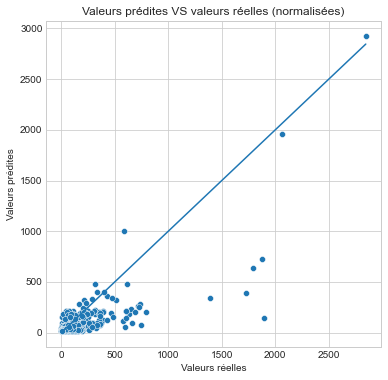

MSE = 0.51
RMSE = 0.72
Coefficient de détermination = 0.43


In [164]:
X_test_CO2_plot = X_test_CO2_.drop([5, 96, 505]).reset_index(drop=True)
y_test_CO2_plot = y_test_CO2_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_CO2_without_energy).drop([5, 96, 505]).reset_index(drop=True)


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_plot['TotalGHGEmissions(Tons)'],
                y = np.exp(std_scale_y_CO2.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


MSE_CO2_without_energy = mean_squared_error(y_test_CO2, pred_lr_CO2_without_energy, squared=True)
print('MSE = {:.2f}'.format(MSE_CO2_without_energy))
print('RMSE = {:.2f}'.format(MSE_CO2_without_energy**(1/2)))
R2_lr_CO2_without_energy = r2_score(y_test_CO2, pred_lr_CO2_without_energy)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_CO2_without_energy))

**3. Sans les catégories de bâtiments ni les données d'énergie**

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': False, 'normalize': True}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


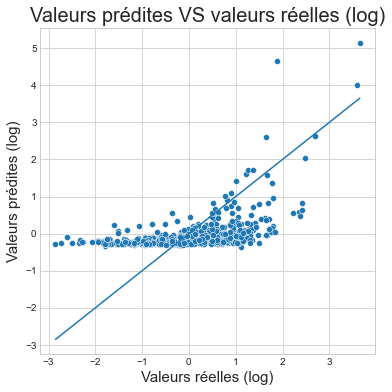

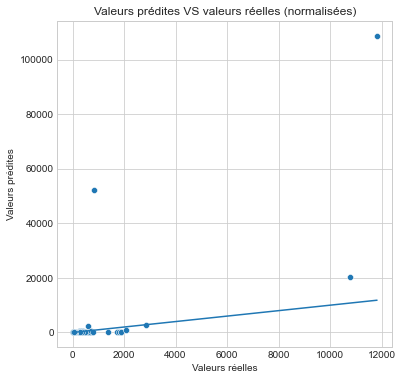

,prédictions
96,170.650809
505,104.516014
5,55.639246
108,13.919162
341,13.700617


In [165]:
X_train_CO2_without_cat_energy = X_train_CO2.iloc[:, 15:-3]
X_test_CO2_without_cat_energy = X_test_CO2.iloc[:, 15:-3]
np.random.seed(5)
lr_CO2_without_cat_energy = GridSearchCV(LinearRegression(),
                                         param_grid = param_lr,
                                         verbose = 2,
                                         cv = cv_train,
                                         scoring = score,
                                         refit = 'neg_mean_absolute_error',
                                         return_train_score = True,
                                         n_jobs = -1
                                        )
lr_CO2_without_cat_energy.fit(X_train_CO2_without_cat_energy, y_train_CO2)
pred_lr_CO2_without_cat_energy = lr_CO2_without_cat_energy.predict(X_test_CO2_without_cat_energy)
print('Meilleurs hyperparamètres : ' + str(lr_CO2_without_cat_energy.best_params_))
fit_time_lr_CO2_without_cat_energy = lr_CO2_without_cat_energy.cv_results_['mean_fit_time'].mean()
pred_time_lr_CO2_without_cat_energy = lr_CO2_without_cat_energy.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_CO2_without_cat_energy))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_CO2_without_cat_energy))


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_CO2, y = pred_lr_CO2_without_cat_energy)
plt.plot([y_test_CO2.min(), y_test_CO2.max()], [y_test_CO2.min(), y_test_CO2.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_['TotalGHGEmissions(Tons)'],
                y = np.exp(std_scale_y_CO2.inverse_transform(pred_lr_CO2_without_cat_energy.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


outliers = pd.DataFrame(np.exp(pred_lr_CO2_without_cat_energy))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

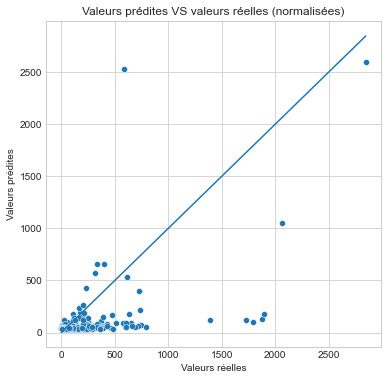

MSE = 0.67
RMSE = 0.82
Coefficient de détermination = 0.25


In [166]:
X_test_CO2_plot = X_test_CO2_.drop([5, 96, 505]).reset_index(drop=True)
y_test_CO2_plot = y_test_CO2_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_CO2_without_cat_energy).drop([5, 96, 505]).reset_index(drop=True)


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_plot['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


MSE_CO2_without_cat_energy = mean_squared_error(y_test_CO2, pred_lr_CO2_without_cat_energy, squared=True)
print('MSE = {:.2f}'.format(MSE_CO2_without_cat_energy))
print('RMSE = {:.2f}'.format(MSE_CO2_without_cat_energy**(1/2)))
R2_lr_CO2_without_cat_energy = r2_score(y_test_CO2, pred_lr_CO2_without_cat_energy)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_CO2_without_cat_energy))

**4. Sans *BuildingType* ni les données d'énergie**

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': True, 'normalize': True}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


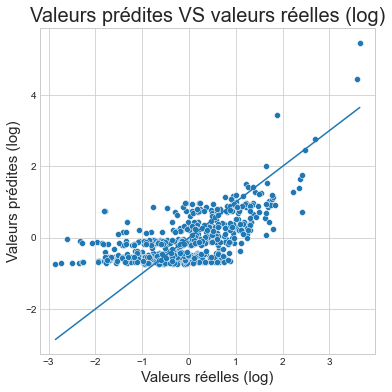

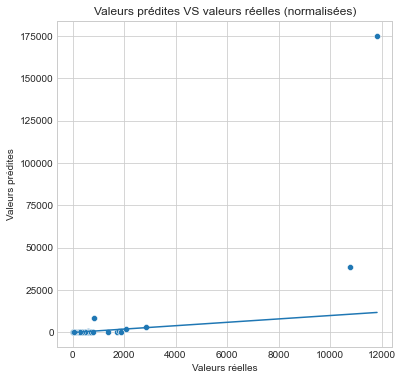

,prédictions
96,234.977742
5,85.549016
505,31.307184
108,16.063442
614,11.668658


In [167]:
X_train_CO24 = X_train_CO2.drop(columns = ['BuildingType_1', 'BuildingType_2', 'BuildingType_5',
                                           'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_CO24 = X_test_CO2.drop(columns = ['BuildingType_1', 'BuildingType_2', 'BuildingType_5',
                                         'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])

np.random.seed(5)
lr_CO24 = GridSearchCV(LinearRegression(),
                       param_grid = param_lr,  
                       verbose = 2,
                       cv = cv_train,
                       scoring = score,
                       refit = 'neg_mean_absolute_error',
                       return_train_score = True,
                       n_jobs = -1
                      )

lr_CO24.fit(X_train_CO24, y_train_CO2)
pred_lr_CO24 = lr_CO24.predict(X_test_CO24)

print('Meilleurs hyperparamètres : ' + str(lr_CO24.best_params_))

fit_time_lr_CO24 = lr_CO24.cv_results_['mean_fit_time'].mean()
pred_time_lr_CO24 = lr_CO24.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_CO24))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_CO24))


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_CO2, y = pred_lr_CO24)
plt.plot([y_test_CO2.min(), y_test_CO2.max()], [y_test_CO2.min(), y_test_CO2.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(pred_lr_CO24.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


outliers = pd.DataFrame(np.exp(pred_lr_CO24))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

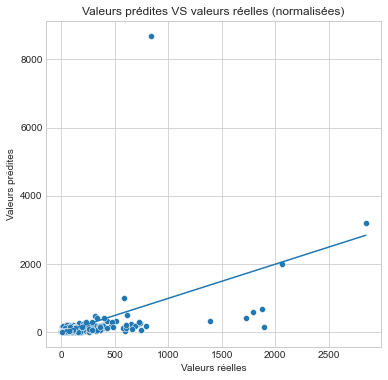

MSE = 0.51
RMSE = 0.72
Coefficient de détermination = 0.43


In [168]:
X_test_CO2_plot = X_test_CO2_.drop([5, 96]).reset_index(drop=True)
y_test_CO2_plot = y_test_CO2_.drop([5, 96]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_CO24).drop([5, 96]).reset_index(drop=True)


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_plot['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


MSE_CO24 = mean_squared_error(y_test_CO2, pred_lr_CO24, squared=True)
print('MSE = {:.2f}'.format(MSE_CO24))
print('RMSE = {:.2f}'.format(MSE_CO24**(1/2)))
R2_lr_CO24 = r2_score(y_test_CO2, pred_lr_CO24)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_CO24))

**5. Sans *PrimaryPropertyType* ni les données d'énergie**

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': True, 'normalize': False}
Temps écoulé pour l'entraînement = 0.01s
Temps écoulé pour la prédiction = 0.00s


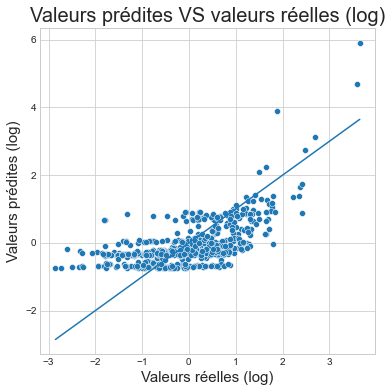

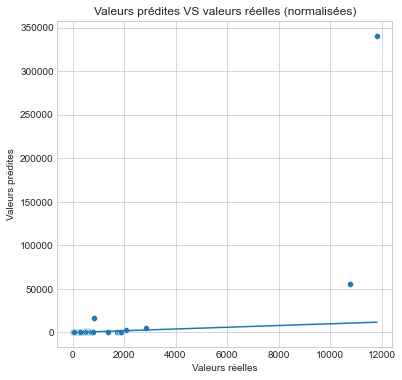

,prédictions
96,367.304139
5,108.885436
505,49.059022
108,23.064397
614,15.751896


In [169]:
X_train_CO25 = X_train_CO2.drop(columns = ['PrimaryPropertyType_0', 'PrimaryPropertyType_1', 'PrimaryPropertyType_2',
                                           'PrimaryPropertyType_3', 'PrimaryPropertyType_4', 'PrimaryPropertyType_5',
                                           'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_CO25 = X_test_CO2.drop(columns = ['PrimaryPropertyType_0', 'PrimaryPropertyType_1', 'PrimaryPropertyType_2',
                                         'PrimaryPropertyType_3', 'PrimaryPropertyType_4', 'PrimaryPropertyType_5',
                                         'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])

np.random.seed(5)
lr_CO25 = GridSearchCV(LinearRegression(),
                       param_grid = param_lr,      
                       verbose = 2,
                       cv = cv_train,
                       scoring = score,
                       refit = 'neg_mean_absolute_error',
                       return_train_score = True,
                       n_jobs = -1
                      )

lr_CO25.fit(X_train_CO25, y_train_CO2)
pred_lr_CO25 = lr_CO25.predict(X_test_CO25)

print('Meilleurs hyperparamètres : ' + str(lr_CO25.best_params_))

fit_time_lr_CO25 = lr_CO25.cv_results_['mean_fit_time'].mean()
pred_time_lr_CO25 = lr_CO25.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_CO25))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_CO25))


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_CO2, y = pred_lr_CO25)
plt.plot([y_test_CO2.min(), y_test_CO2.max()], [y_test_CO2.min(), y_test_CO2.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(pred_lr_CO25.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


outliers = pd.DataFrame(np.exp(pred_lr_CO25))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

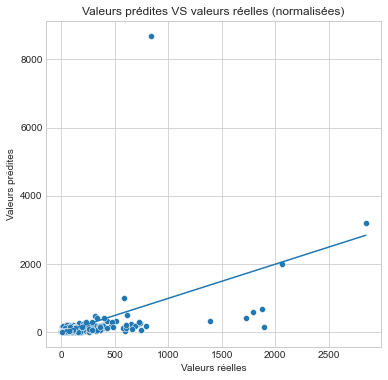

MSE = 0.54
RMSE = 0.73
Coefficient de détermination = 0.40


In [170]:
X_test_CO2_plot = X_test_CO2_.drop([5, 96]).reset_index(drop=True)
y_test_CO2_plot = y_test_CO2_.drop([5, 96]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_CO24).drop([5, 96]).reset_index(drop=True)


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_plot['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


MSE_CO25 = mean_squared_error(y_test_CO2, pred_lr_CO25, squared=True)
print('MSE = {:.2f}'.format(MSE_CO25))
print('RMSE = {:.2f}'.format(MSE_CO25**(1/2)))
R2_lr_CO25 = r2_score(y_test_CO2, pred_lr_CO25)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_CO25))

**6. Sans *LargestPropertyUseType* ni les données d'énergie**

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': True, 'normalize': False}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


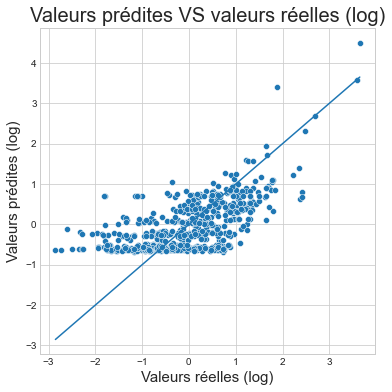

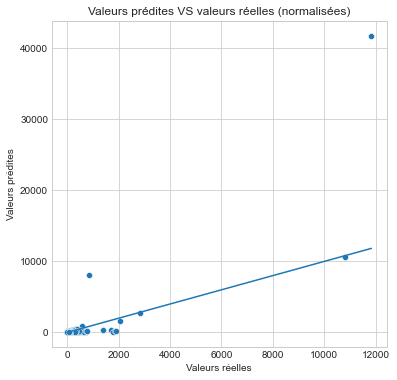

,prédictions
96,89.728769
5,35.931392
505,29.799036
108,14.648141
614,10.024614


In [171]:
X_train_CO26 = X_train_CO2.drop(columns = ['LargestPropertyUseType_0', 'LargestPropertyUseType_1', 'LargestPropertyUseType_2',
                                           'LargestPropertyUseType_3', 'LargestPropertyUseType_4', 'LargestPropertyUseType_5',
                                           'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_CO26 = X_test_CO2.drop(columns = ['LargestPropertyUseType_0', 'LargestPropertyUseType_1', 'LargestPropertyUseType_2',
                                         'LargestPropertyUseType_3', 'LargestPropertyUseType_4', 'LargestPropertyUseType_5',
                                         'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])

np.random.seed(5)
lr_CO26 = GridSearchCV(LinearRegression(),
                       param_grid = param_lr, 
                       verbose = 2,
                       cv = cv_train,
                       scoring = score,
                       refit = 'neg_mean_absolute_error',
                       return_train_score = True,
                       n_jobs = -1
                      )

lr_CO26.fit(X_train_CO26, y_train_CO2)
pred_lr_CO26 = lr_CO26.predict(X_test_CO26)

print('Meilleurs hyperparamètres : ' + str(lr_CO26.best_params_))

fit_time_lr_CO26 = lr_CO26.cv_results_['mean_fit_time'].mean()
pred_time_lr_CO26 = lr_CO26.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_CO26))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_CO26))


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_CO2, y = pred_lr_CO26)
plt.plot([y_test_CO2.min(), y_test_CO2.max()], [y_test_CO2.min(), y_test_CO2.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(pred_lr_CO26.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


outliers = pd.DataFrame(np.exp(pred_lr_CO26))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

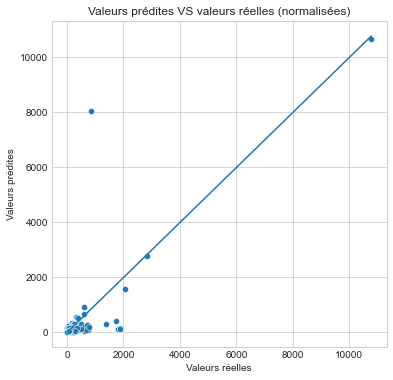

MSE = 0.55
RMSE = 0.74
Coefficient de détermination = 0.39


In [172]:
X_test_CO2_plot = X_test_CO2_.drop([96]).reset_index(drop=True)
y_test_CO2_plot = y_test_CO2_.drop([96]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_CO26).drop([96]).reset_index(drop=True)


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_plot['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


MSE_CO26 = mean_squared_error(y_test_CO2, pred_lr_CO26, squared=True)
print('MSE = {:.2f}'.format(MSE_CO26))
print('RMSE = {:.2f}'.format(MSE_CO26**(1/2)))
R2_lr_CO26 = r2_score(y_test_CO2, pred_lr_CO26)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_CO26))

**7. Sans *BuildingType* et *PrimaryPropertyType* ni les données d'énergie**

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': True, 'normalize': True}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


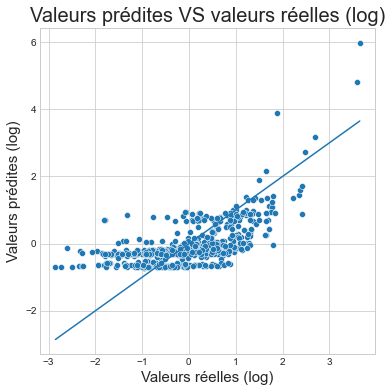

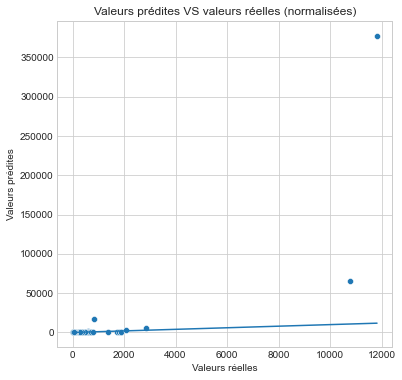

,prédictions
96,393.314433
5,121.843127
505,49.037148
108,23.992334
614,15.520900


In [173]:
X_train_CO27 = X_train_CO2.drop(columns = ['BuildingType_1', 'BuildingType_2', 'BuildingType_5',
                                           'PrimaryPropertyType_0', 'PrimaryPropertyType_1', 'PrimaryPropertyType_2',
                                           'PrimaryPropertyType_3', 'PrimaryPropertyType_4', 'PrimaryPropertyType_5',
                                           'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_CO27 = X_test_CO2.drop(columns = ['BuildingType_1', 'BuildingType_2', 'BuildingType_5',
                                         'PrimaryPropertyType_0', 'PrimaryPropertyType_1', 'PrimaryPropertyType_2',
                                         'PrimaryPropertyType_3', 'PrimaryPropertyType_4', 'PrimaryPropertyType_5',
                                         'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])

np.random.seed(5)
lr_CO27 = GridSearchCV(LinearRegression(),
                       param_grid = param_lr,      
                       verbose = 2,
                       cv = cv_train,
                       scoring = score,
                       refit = 'neg_mean_absolute_error',
                       return_train_score = True,
                       n_jobs = -1
                      )

lr_CO27.fit(X_train_CO27, y_train_CO2)
pred_lr_CO27 = lr_CO27.predict(X_test_CO27)

print('Meilleurs hyperparamètres : ' + str(lr_CO27.best_params_))

fit_time_lr_CO27 = lr_CO27.cv_results_['mean_fit_time'].mean()
pred_time_lr_CO27 = lr_CO27.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_CO27))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_CO27))


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_CO2, y = pred_lr_CO27)
plt.plot([y_test_CO2.min(), y_test_CO2.max()], [y_test_CO2.min(), y_test_CO2.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(pred_lr_CO27.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


outliers = pd.DataFrame(np.exp(pred_lr_CO27))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

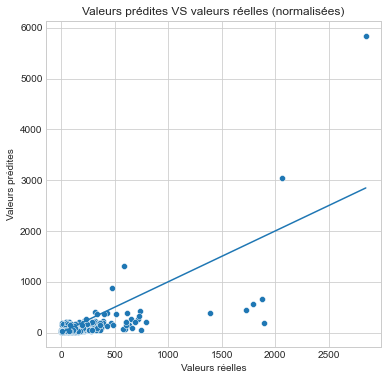

MSE = 0.54
RMSE = 0.73
Coefficient de détermination = 0.40


In [174]:
X_test_CO2_plot = X_test_CO2_.drop([5, 96, 505]).reset_index(drop=True)
y_test_CO2_plot = y_test_CO2_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_CO27).drop([5, 96, 505]).reset_index(drop=True)


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_plot['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


MSE_CO27 = mean_squared_error(y_test_CO2, pred_lr_CO27, squared=True)
print('MSE = {:.2f}'.format(MSE_CO27))
print('RMSE = {:.2f}'.format(MSE_CO27**(1/2)))
R2_lr_CO27 = r2_score(y_test_CO2, pred_lr_CO27)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_CO27))

**8. Sans *BuildingType* et *LargestPropertyUseType* ni les données d'énergie**

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': True, 'normalize': True}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


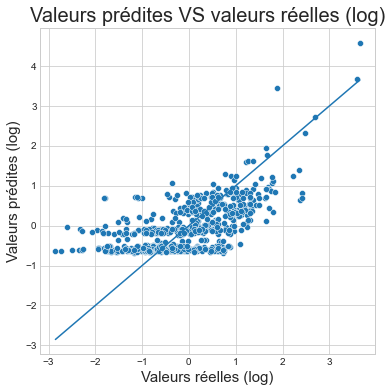

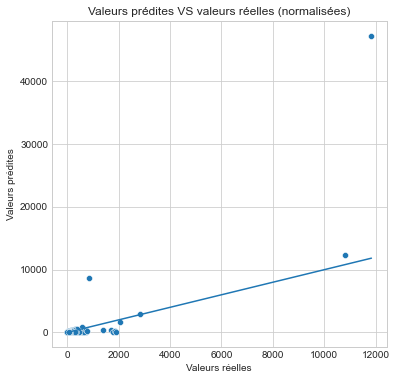

,prédictions
96,97.503566
5,39.787667
505,31.443658
108,15.334642
614,10.118463


In [175]:
X_train_CO28 = X_train_CO2.drop(columns = ['BuildingType_1', 'BuildingType_2', 'BuildingType_5',
                                           'LargestPropertyUseType_0', 'LargestPropertyUseType_1', 'LargestPropertyUseType_2',
                                           'LargestPropertyUseType_3', 'LargestPropertyUseType_4', 'LargestPropertyUseType_5',
                                           'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_CO28 = X_test_CO2.drop(columns = ['BuildingType_1', 'BuildingType_2', 'BuildingType_5',
                                         'LargestPropertyUseType_0', 'LargestPropertyUseType_1', 'LargestPropertyUseType_2',
                                         'LargestPropertyUseType_3', 'LargestPropertyUseType_4', 'LargestPropertyUseType_5',
                                         'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])

np.random.seed(5)
lr_CO28 = GridSearchCV(LinearRegression(),
                       param_grid = param_lr,    
                       verbose = 2,
                       cv = cv_train,
                       scoring = score,
                       refit = 'neg_mean_absolute_error',
                       return_train_score = True,
                       n_jobs = -1
                      )

lr_CO28.fit(X_train_CO28, y_train_CO2)
pred_lr_CO28 = lr_CO28.predict(X_test_CO28)

print('Meilleurs hyperparamètres : ' + str(lr_CO28.best_params_))

fit_time_lr_CO28 = lr_CO28.cv_results_['mean_fit_time'].mean()
pred_time_lr_CO28 = lr_CO28.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_CO28))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_CO28))


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_CO2, y = pred_lr_CO28)
plt.plot([y_test_CO2.min(), y_test_CO2.max()], [y_test_CO2.min(), y_test_CO2.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(pred_lr_CO28.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


outliers = pd.DataFrame(np.exp(pred_lr_CO28))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

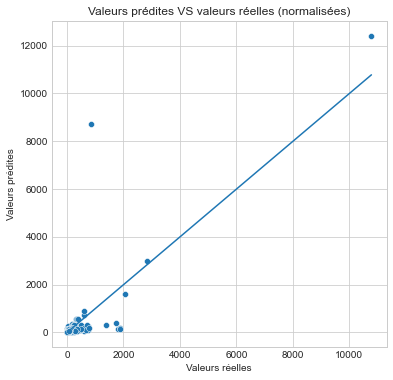

MSE = 0.55
RMSE = 0.74
Coefficient de détermination = 0.39


In [176]:
X_test_CO2_plot = X_test_CO2_.drop([96]).reset_index(drop=True)
y_test_CO2_plot = y_test_CO2_.drop([96]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_CO28).drop([96]).reset_index(drop=True)


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_plot['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


MSE_CO28 = mean_squared_error(y_test_CO2, pred_lr_CO28, squared=True)
print('MSE = {:.2f}'.format(MSE_CO28))
print('RMSE = {:.2f}'.format(MSE_CO28**(1/2)))
R2_lr_CO28 = r2_score(y_test_CO2, pred_lr_CO28)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_CO28))

**9. Sans *PrimaryPropertyType* et *LargestPropertyUseType* ni les données d'énergie**

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': True, 'normalize': True}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


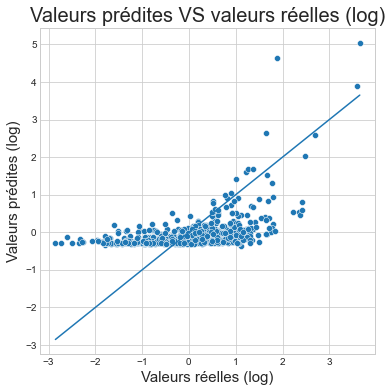

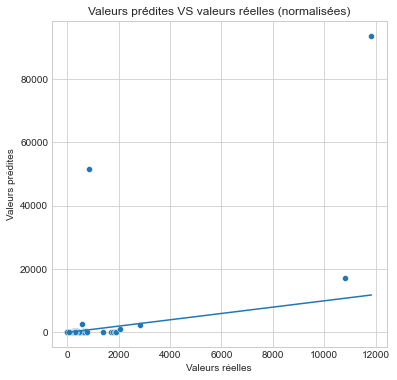

,prédictions
96,154.325267
505,103.609083
5,49.325318
341,14.076845
108,13.327689


In [178]:
X_train_CO29 = X_train_CO2.drop(columns = ['PrimaryPropertyType_0', 'PrimaryPropertyType_1', 'PrimaryPropertyType_2',
                                           'PrimaryPropertyType_3', 'PrimaryPropertyType_4', 'PrimaryPropertyType_5',
                                           'LargestPropertyUseType_0', 'LargestPropertyUseType_1', 'LargestPropertyUseType_2',
                                           'LargestPropertyUseType_3', 'LargestPropertyUseType_4', 'LargestPropertyUseType_5',
                                           'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_CO29 = X_test_CO2.drop(columns = ['PrimaryPropertyType_0', 'PrimaryPropertyType_1', 'PrimaryPropertyType_2',
                                         'PrimaryPropertyType_3', 'PrimaryPropertyType_4', 'PrimaryPropertyType_5',
                                         'LargestPropertyUseType_0', 'LargestPropertyUseType_1', 'LargestPropertyUseType_2',
                                         'LargestPropertyUseType_3', 'LargestPropertyUseType_4', 'LargestPropertyUseType_5',
                                         'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])

np.random.seed(5)
lr_CO29 = GridSearchCV(LinearRegression(),
                       param_grid = param_lr,    
                       verbose = 2,
                       cv = cv_train,
                       scoring = score,
                       refit = 'neg_mean_absolute_error',
                       return_train_score = True,
                       n_jobs = -1
                      )

lr_CO29.fit(X_train_CO29, y_train_CO2)
pred_lr_CO29 = lr_CO29.predict(X_test_CO29)

print('Meilleurs hyperparamètres : ' + str(lr_CO29.best_params_))

fit_time_lr_CO29 = lr_CO29.cv_results_['mean_fit_time'].mean()
pred_time_lr_CO29 = lr_CO29.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_CO29))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_CO29))


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_CO2, y = pred_lr_CO29)
plt.plot([y_test_CO2.min(), y_test_CO2.max()], [y_test_CO2.min(), y_test_CO2.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(pred_lr_CO29.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


outliers = pd.DataFrame(np.exp(pred_lr_CO29))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

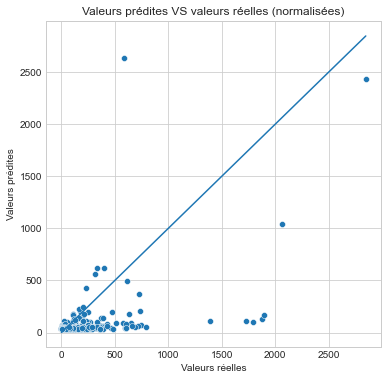

MSE = 0.67
RMSE = 0.82
Coefficient de détermination = 0.25


In [179]:
X_test_CO2_plot = X_test_CO2_.drop([5, 96, 505]).reset_index(drop=True)
y_test_CO2_plot = y_test_CO2_.drop([5, 96, 505]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_CO29).drop([5, 96, 505]).reset_index(drop=True)


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_plot['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


MSE_CO29 = mean_squared_error(y_test_CO2, pred_lr_CO29, squared=True)
print('MSE = {:.2f}'.format(MSE_CO29))
print('RMSE = {:.2f}'.format(MSE_CO29**(1/2)))
R2_lr_CO29 = r2_score(y_test_CO2, pred_lr_CO29)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_CO29))

**10. Seulement avec les données d'énergie**

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs hyperparamètres : {'fit_intercept': False, 'normalize': True}
Temps écoulé pour l'entraînement = 0.00s
Temps écoulé pour la prédiction = 0.00s


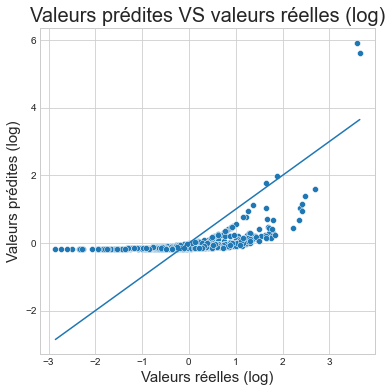

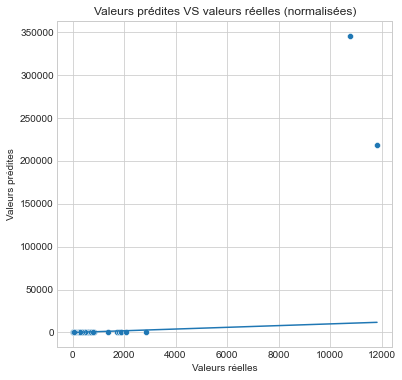

,prédictions
5,370.844711
96,272.442950
505,7.357326
87,5.976037
108,4.955659


In [180]:
X_train_CO2_only_energy = X_train_CO2[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']]
X_test_CO2_only_energy = X_test_CO2[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']]
np.random.seed(5)
lr_CO2_only_energy = GridSearchCV(LinearRegression(),
                                  param_grid = param_lr,
                                  verbose = 2,
                                  cv = cv_train,
                                  scoring = score,
                                  refit = 'neg_mean_absolute_error',
                                  return_train_score = True,
                                  n_jobs = -1
                                 )
lr_CO2_only_energy.fit(X_train_CO2_only_energy, y_train_CO2)
pred_lr_CO2_only_energy = lr_CO2_only_energy.predict(X_test_CO2_only_energy)
print('Meilleurs hyperparamètres : ' + str(lr_CO2_only_energy.best_params_))
fit_time_lr_CO2_only_energy = lr_CO2_only_energy.cv_results_['mean_fit_time'].mean()
pred_time_lr_CO2_only_energy = lr_CO2_only_energy.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_lr_CO2_only_energy))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_lr_CO2_only_energy))


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_CO2, y = pred_lr_CO2_only_energy)
plt.plot([y_test_CO2.min(), y_test_CO2.max()], [y_test_CO2.min(), y_test_CO2.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(pred_lr_CO2_only_energy.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


outliers = pd.DataFrame(np.exp(pred_lr_CO2_only_energy))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

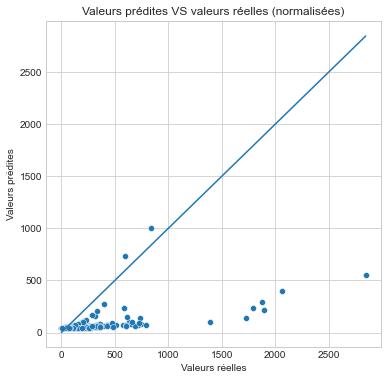

MSE = 0.66
RMSE = 0.82
Coefficient de détermination = 0.26


In [181]:
X_test_CO2_plot = X_test_CO2_.drop([5, 96]).reset_index(drop=True)
y_test_CO2_plot = y_test_CO2_.drop([5, 96]).reset_index(drop=True)
pred_plot = pd.Series(pred_lr_CO2_only_energy).drop([5, 96]).reset_index(drop=True)


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_plot['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


MSE_CO2_only_energy = mean_squared_error(y_test_CO2, pred_lr_CO2_only_energy, squared=True)
print('MSE = {:.2f}'.format(MSE_CO2_only_energy))
print('RMSE = {:.2f}'.format(MSE_CO2_only_energy**(1/2)))
R2_lr_CO2_only_energy = r2_score(y_test_CO2, pred_lr_CO2_only_energy)
print('Coefficient de détermination = {:.2f}'.format(R2_lr_CO2_only_energy))

**Comparaison des modèles**

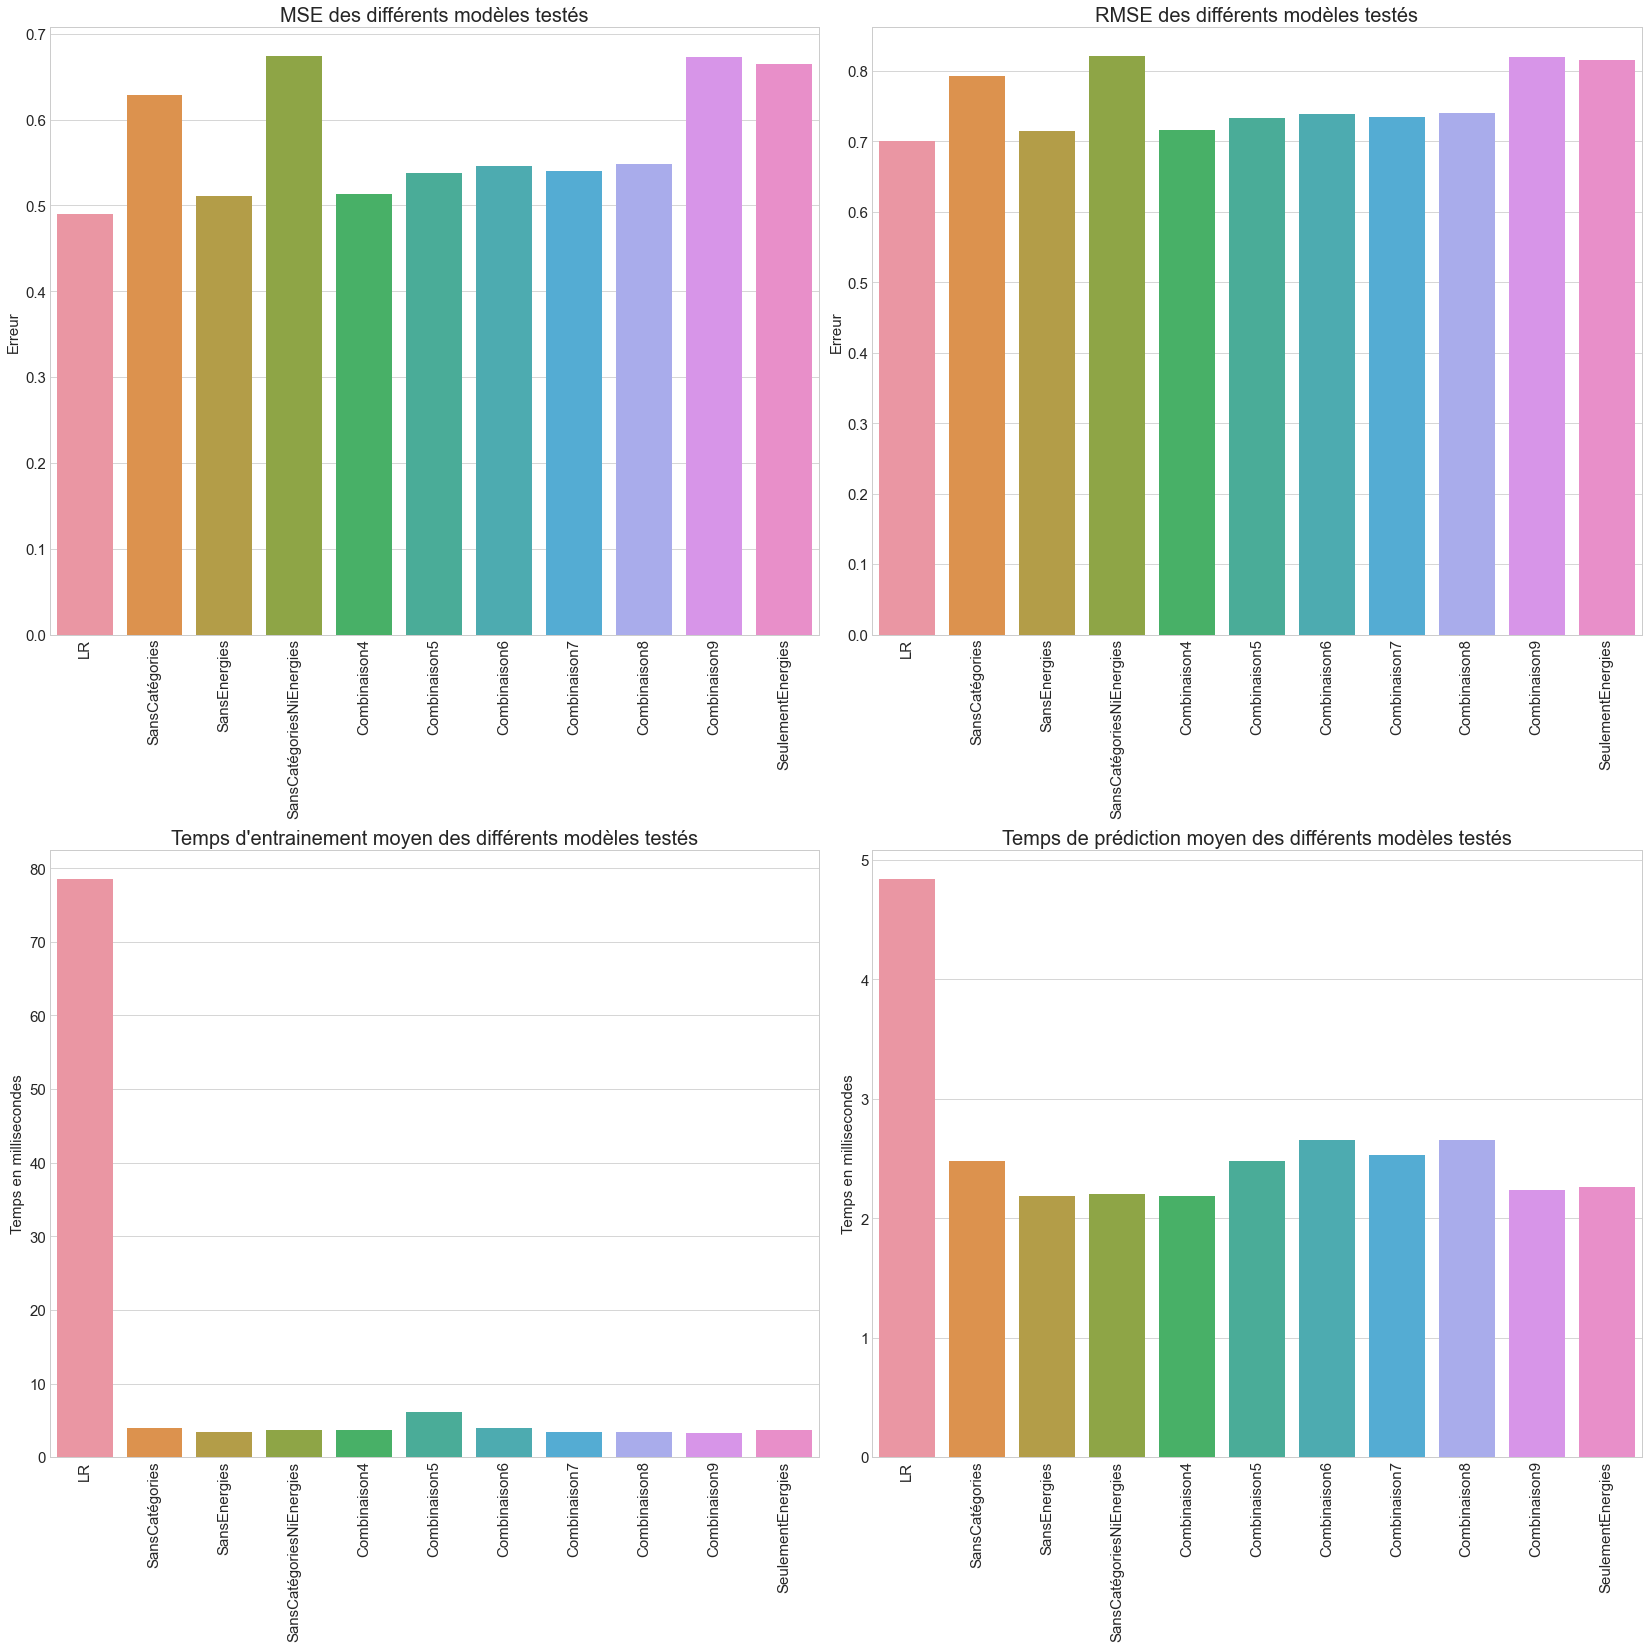

In [182]:
fig = plt.figure(figsize = (23, 23))
listeModeles = ['LR', 'SansCatégories', 'SansEnergies', 'SansCatégoriesNiEnergies', 'Combinaison4', 'Combinaison5',
                'Combinaison6', 'Combinaison7', 'Combinaison8', 'Combinaison9', 'SeulementEnergies']

listeMSE = [baseline_CO2_error, MSE_CO2_without_cat, MSE_CO2_without_energy, MSE_CO2_without_cat_energy, MSE_CO24, MSE_CO25, MSE_CO26, MSE_CO27, MSE_CO28, MSE_CO29, MSE_CO2_only_energy]
listeRMSE = [elt**(1/2) for elt in listeMSE]
listeFitTime_s = [fit_time_lr_CO2, fit_time_lr_CO2_without_cat, fit_time_lr_CO2_without_energy, fit_time_lr_CO2_without_cat_energy, fit_time_lr_CO24, fit_time_lr_CO25, fit_time_lr_CO26, fit_time_lr_CO27, fit_time_lr_CO28, fit_time_lr_CO29, fit_time_lr_CO2_only_energy]
listeFitTime = [1000*elt for elt in listeFitTime_s]
listePredTime_s = [pred_time_lr_CO2, pred_time_lr_CO2_without_cat, pred_time_lr_CO2_without_energy, pred_time_lr_CO2_without_cat_energy, pred_time_lr_CO24, pred_time_lr_CO25, pred_time_lr_CO26, pred_time_lr_CO27, pred_time_lr_CO28, pred_time_lr_CO29, pred_time_lr_CO2_only_energy]
listePredTime = [1000*elt for elt in listePredTime_s]

plt.subplot(2,2,1)
sns.barplot(x = listeModeles, y = listeMSE)
plt.title('MSE des différents modèles testés', fontsize = 20)
plt.xticks(rotation = 'vertical')
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,2)
sns.barplot(x = listeModeles, y = listeRMSE)
plt.title('RMSE des différents modèles testés', fontsize = 20)
plt.xticks(rotation = 'vertical')
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,3)
sns.barplot(x = listeModeles, y = listeFitTime)
plt.title('Temps d\'entrainement moyen des différents modèles testés', fontsize = 20)
plt.xticks(rotation = 'vertical')
plt.ylabel('Temps en millisecondes', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,4)
sns.barplot(x = listeModeles, y = listePredTime)
plt.title('Temps de prédiction moyen des différents modèles testés', fontsize = 20)
plt.xticks(rotation = 'vertical')
plt.ylabel('Temps en millisecondes', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

fig.tight_layout()
plt.show()

In [183]:
for i in range(len(listeMSE)) :
    print(str(listeModeles[i]) + ' : MSE = ' + str(listeMSE[i]))

LR : MSE = 0.490419709680246
SansCatégories : MSE = 0.6281892159393645
SansEnergies : MSE = 0.511362752183876
SansCatégoriesNiEnergies : MSE = 0.6736304344923346
Combinaison4 : MSE = 0.5131273918734737
Combinaison5 : MSE = 0.537145855842026
Combinaison6 : MSE = 0.5463167470929908
Combinaison7 : MSE = 0.5397738081530548
Combinaison8 : MSE = 0.5476139183200169
Combinaison9 : MSE = 0.672389627362277
SeulementEnergies : MSE = 0.6647505060183659


Nous choisissons donc la combinaison de variables qui a la MSE la plus faible : *SansEnergies*.

In [184]:
X_train_CO2 = X_train_CO2.drop(columns = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])
X_test_CO2 = X_test_CO2.drop(columns = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'])

[Retour au sommaire](#Sommaire)
### Régression Ridge <a class="anchor" id="Partie3_4"></a>
#### Mise en place du modèle

In [185]:
np.random.seed(5)
ridge_CO2 = GridSearchCV(Ridge(),
                         param_grid = param_ridge,
                         verbose = 2,
                         cv = cv_train,
                         scoring = score,
                         refit = 'neg_mean_absolute_error',
                         return_train_score = True,
                         n_jobs = -1
                        )

ridge_CO2.fit(X_train_CO2, y_train_CO2)
pred_ridge_CO2 = ridge_CO2.predict(X_test_CO2)

print('Meilleurs hyperparamètres : ' + str(ridge_CO2.best_params_))

fit_time_ridge_CO2 = ridge_CO2.cv_results_['mean_fit_time'].mean()
pred_time_ridge_CO2 = ridge_CO2.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}ms'.format(1000*fit_time_ridge_CO2))
print('Temps écoulé pour la prédiction = {:.2f}ms'.format(1000*pred_time_ridge_CO2))

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
Meilleurs hyperparamètres : {'alpha': 0.03292971255097151, 'fit_intercept': True, 'normalize': True}
Temps écoulé pour l'entraînement = 5.65ms
Temps écoulé pour la prédiction = 3.81ms


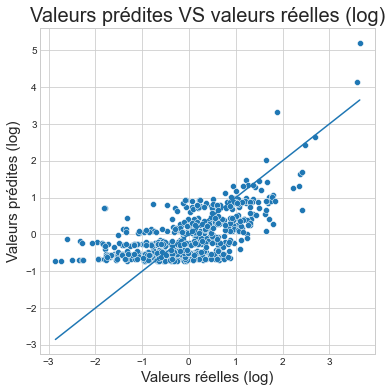

In [186]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_CO2, y = pred_ridge_CO2)
plt.plot([y_test_CO2.min(), y_test_CO2.max()], [y_test_CO2.min(), y_test_CO2.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

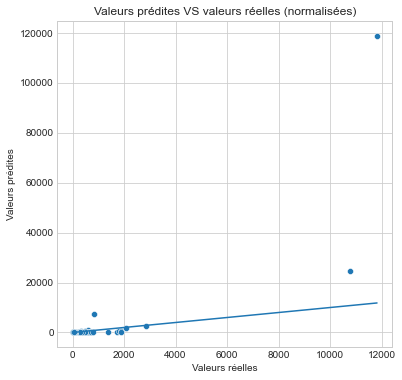

In [188]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(pred_ridge_CO2.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [189]:
outliers = pd.DataFrame(np.exp(pred_ridge_CO2))
outliers.columns = ['prédictions']
outliers.sort_values(by='prédictions', ascending=False).head()

,prédictions
96,181.166169
5,63.063723
505,28.113604
108,13.936578
614,11.353689


In [190]:
X_test_CO2_plot = X_test_CO2_.drop([5, 96]).reset_index(drop=True)
y_test_CO2_plot = y_test_CO2_.drop([5, 96]).reset_index(drop=True)
pred_plot = pd.Series(pred_ridge_CO2).drop([5, 96]).reset_index(drop=True)

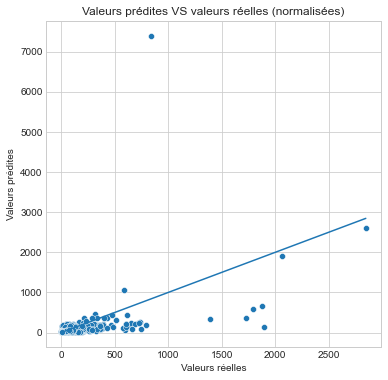

In [191]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_plot['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(np.array(pred_plot).reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_plot['TotalGHGEmissions(Tons)'].min(), X_test_CO2_plot['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [192]:
MSE_CO2_ridge = mean_squared_error(y_test_CO2, pred_ridge_CO2, squared=True)
print('MSE = {:.2f}'.format(MSE_CO2_ridge))
print('RMSE = {:.2f}'.format(MSE_CO2_ridge**(1/2)))

R2_ridge_CO2 = r2_score(y_test_CO2, pred_ridge_CO2)
print('Coefficient de détermination = {:.2f}'.format(R2_ridge_CO2))

MSE = 0.51
RMSE = 0.72
Coefficient de détermination = 0.43


[Retour au sommaire](#Sommaire)
### Forêt aléatoire <a class="anchor" id="Partie3_5"></a>

In [193]:
np.random.seed(5)

rfr_CO2 = GridSearchCV(RandomForestRegressor(),
                       param_grid = param_rfr,
                       verbose = 2,
                       cv = cv_train,
                       scoring = score,
                       refit = 'neg_mean_absolute_error',
                       return_train_score = True,
                       n_jobs = -1
                      )

In [194]:
rfr_CO2.fit(X_train_CO2, y_train_CO2)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 15, 20, 25, 30, 35, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 500, 800, 1000, 1200]},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [195]:
pred_rfr_CO2 = rfr_CO2.predict(X_test_CO2)

In [196]:
print('Meilleurs hyperparamètres : ' + str(rfr_CO2.best_params_))

fit_time_rfr_CO2 = rfr_CO2.cv_results_['mean_fit_time'].mean()
pred_time_rfr_CO2 = rfr_CO2.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_rfr_CO2))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_rfr_CO2))

Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'n_estimators': 300}
Temps écoulé pour l'entraînement = 3.86s
Temps écoulé pour la prédiction = 0.14s


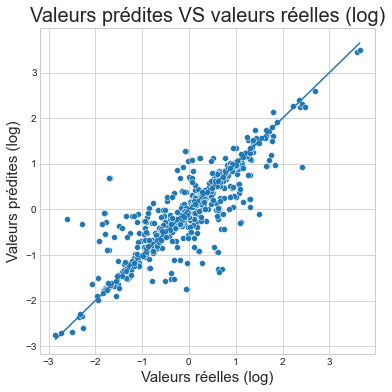

In [197]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_CO2, y = pred_rfr_CO2)
plt.plot([y_test_CO2.min(), y_test_CO2.max()], [y_test_CO2.min(), y_test_CO2.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

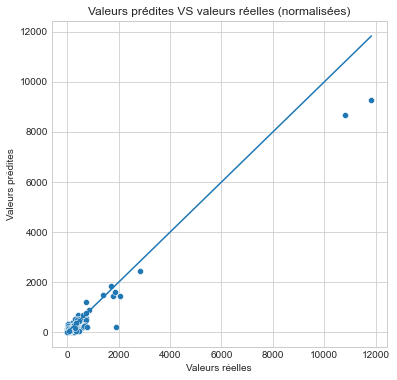

In [198]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_CO2_['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_CO2.inverse_transform(pred_rfr_CO2.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()],
         [X_test_CO2_['TotalGHGEmissions(Tons)'].min(), X_test_CO2_['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [199]:
MSE_rfr_CO2 = mean_squared_error(y_test_CO2, pred_rfr_CO2, squared=True)
print('MSE = {:.2f}'.format(MSE_rfr_CO2))
print('RMSE = {:.2f}'.format(MSE_rfr_CO2**(1/2)))

R2_rfr_CO2 = r2_score(y_test_CO2, pred_rfr_CO2)
print('Coefficient de détermination = {:.2f}'.format(R2_rfr_CO2))

MSE = 0.24
RMSE = 0.49
Coefficient de détermination = 0.74


[Retour au sommaire](#Sommaire)
### Comparaison des modèles <a class="anchor" id="Partie3_6"></a>

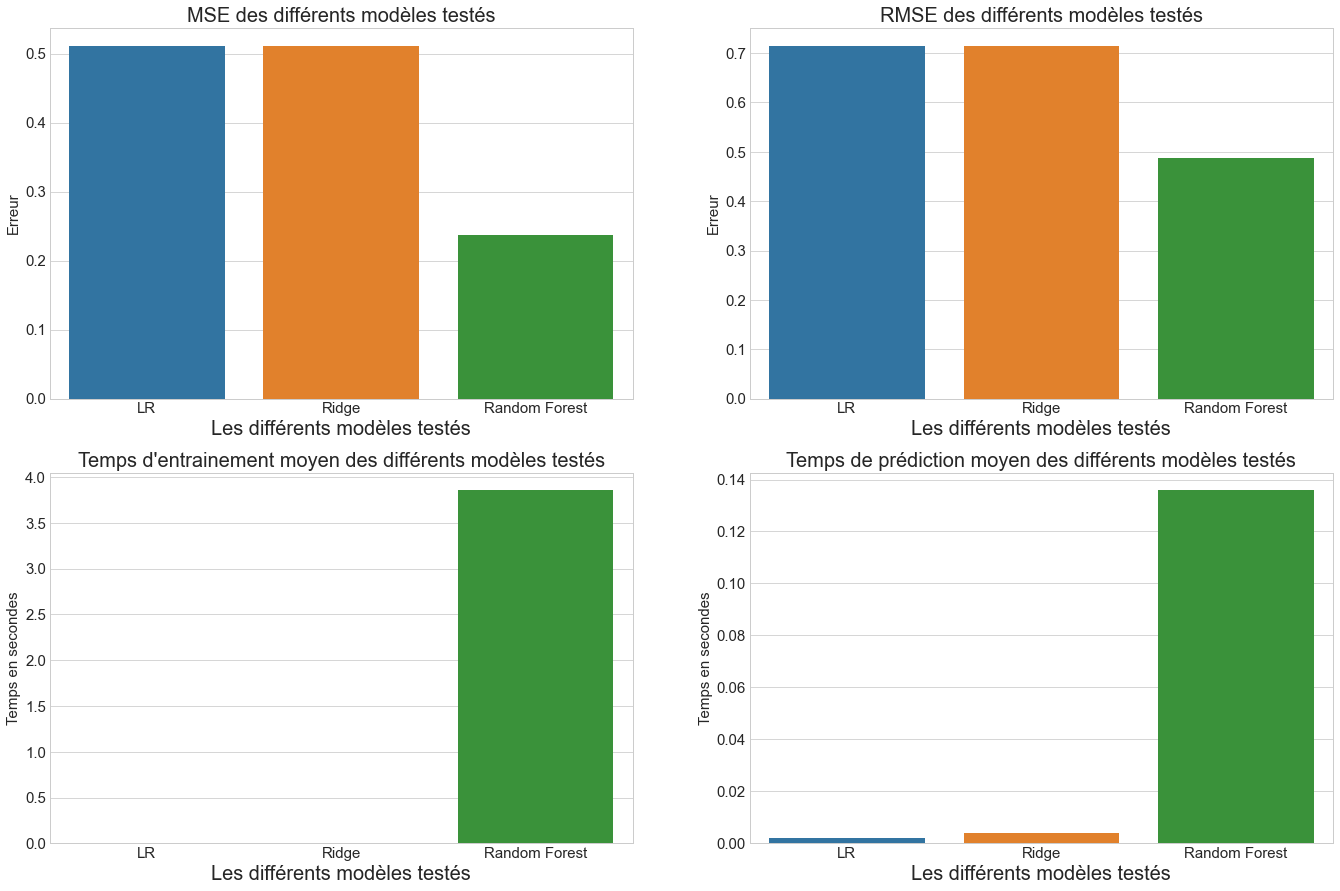

In [200]:
fig = plt.figure(figsize = (23, 15))
listeModeles = ['LR', 'Ridge', 'Random Forest']

listeMSE = [MSE_CO2_without_energy, MSE_CO2_ridge, MSE_rfr_CO2]
listeRMSE = [elt**(1/2) for elt in listeMSE]
listeFitTime = [fit_time_lr_CO2_without_energy, fit_time_ridge_CO2, fit_time_rfr_CO2]
listePredTime = [pred_time_lr_CO2_without_energy, pred_time_ridge_CO2, pred_time_rfr_CO2]

plt.subplot(2,2,1)
sns.barplot(x = listeModeles, y = listeMSE)
plt.title('MSE des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,2)
sns.barplot(x = listeModeles, y = listeRMSE)
plt.title('RMSE des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,3)
sns.barplot(x = listeModeles, y = listeFitTime)
plt.title('Temps d\'entrainement moyen des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Temps en secondes', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,4)
sns.barplot(x = listeModeles, y = listePredTime)
plt.title('Temps de prédiction moyen des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Temps en secondes', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

In [201]:
listeFitTime

[0.0033525586128234867, 0.005646251916885376, 3.855299527730261]

Le meilleur modèle est encore une fois la forêt aléatoire. Regardons maintenant si l'*EnergyStarScore* peut nous permettre d'améliorer notre modèle.

[Retour au sommaire](#Sommaire)
## Impact de l'EnergyStarScore  <a class="anchor" id="Partie4"></a>
### Préparation des données <a class="anchor" id="Partie4_1"></a>
Dans la suite, nous allons utiliser la variable ```EnergyStarScore```.

In [202]:
df_Elec_.head()

,BuildingType_1,BuildingType_2,BuildingType_5,PrimaryPropertyType_0,PrimaryPropertyType_1,PrimaryPropertyType_2,PrimaryPropertyType_3,PrimaryPropertyType_4,PrimaryPropertyType_5,LargestPropertyUseType_0,...,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions(Tons),SiteEnergyUse(log),TotalGHGEmissions(log)
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,88434,88434.0,2023032.0,3686160.0,1272388.0,65.0,6981428.0,249.43,15.758764,5.519178
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,88502,83880.0,0.0,3905411.0,4448985.0,51.0,8354235.0,263.51,15.938279,5.574091
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,961990,757243.0,19660404.0,49762435.0,3709900.0,18.0,73130656.0,2061.48,18.107758,7.631179
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,61320,61320.0,23458518.0,2769023.0,2001894.0,1.0,28229320.0,1936.34,17.155872,7.568555
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,107430,123445.0,0.0,6066245.0,8763105.0,67.0,14829099.0,507.70,16.512102,6.229891


In [203]:
X_ESS = df_Elec_.iloc[:,:-2]
X_ESS = X_ESS.drop(columns = ['SiteEnergyUse(kBtu)'])
y_ESS = df_Elec_.iloc[:,-1]

X_train_ESS_, X_test_ESS_, y_train_ESS_, y_test_ESS_ = train_test_split(X_ESS, y_ESS, test_size=0.3,
                                                                                    random_state=42)

X_train_ESS_ = X_train_ESS_.reset_index(drop=True)
X_test_ESS_ = X_test_ESS_.reset_index(drop=True)
y_train_ESS_ = y_train_ESS_.reset_index(drop=True)
y_test_ESS_ = y_test_ESS_.reset_index(drop=True)

In [204]:
print(X_train_ESS_.shape)
print(X_test_ESS_.shape)
print(y_train_ESS_.shape)
print(y_test_ESS_.shape)

(1505, 26)
(645, 26)
(1505,)
(645,)


In [205]:
X_train_ESS_.head()

,BuildingType_1,BuildingType_2,BuildingType_5,PrimaryPropertyType_0,PrimaryPropertyType_1,PrimaryPropertyType_2,PrimaryPropertyType_3,PrimaryPropertyType_4,PrimaryPropertyType_5,LargestPropertyUseType_0,...,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ENERGYSTARScore,TotalGHGEmissions(Tons)
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,7.0,277486,80283,197203,178625.0,0.0,12729856.0,0.0,63.0,88.74
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,103000,0,103000,103000.0,0.0,2338435.0,2515995.0,42.0,149.93
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,24152,0,24152,24152.0,0.0,50897.0,0.0,100.0,0.35
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,15.0,115775,31535,84240,150000.0,0.0,2892548.0,0.0,93.0,20.16
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,23500,0,23500,23500.0,0.0,1170650.0,470945.0,28.0,33.17


In [206]:
y_train_ESS_.head()

0    4.485711
1    5.010169
2   -1.049822
3    3.003700
4    3.501646
Name: TotalGHGEmissions(log), dtype: float64

#### Standardisation des variables numériques
Nous allons standardiser toutes nos variables numériques de ```X_train_ESS_``` c'est à dire toutes les variables sauf ```LargestPropertyUseType``` qui est une variable catégorielle.

In [207]:
std_scale_X_ESS = preprocessing.StandardScaler().fit(X_train_ESS_.iloc[:, 4:-1])
X_train_std_ESS = std_scale_X_ESS.transform(X_train_ESS_.iloc[:, 4:-1])
X_test_std_ESS = std_scale_X_ESS.transform(X_test_ESS_.iloc[:, 4:-1])

std_scale_y_ESS = preprocessing.StandardScaler().fit(np.array(y_train_ESS_).reshape(-1, 1))
y_train_std_ESS = std_scale_y_ESS.transform(np.array(y_train_ESS_).reshape(-1, 1))
y_test_std_ESS = std_scale_y_ESS.transform(np.array(y_test_ESS_).reshape(-1, 1))

In [208]:
X_train_ESS = X_train_ESS_.iloc[:, :4].join(pd.DataFrame(X_train_std_ESS))
X_train_ESS.columns = X_train_ESS_.columns[:-1]
X_test_ESS = X_test_ESS_.iloc[:, :4].join(pd.DataFrame(X_test_std_ESS))
X_test_ESS.columns = X_train_ESS_.columns[:-1]

In [209]:
y_data_train_ESS = pd.DataFrame(y_train_std_ESS)
y_data_train_ESS.columns = ['TotalGHGEmissions(log)']
y_train_ESS = y_data_train_ESS['TotalGHGEmissions(log)']

y_data_test_ESS = pd.DataFrame(y_test_std_ESS)
y_data_test_ESS.columns = ['TotalGHGEmissions(log)']
y_test_ESS = y_data_test_ESS['TotalGHGEmissions(log)']

In [210]:
X_train_ESS.head()

,BuildingType_1,BuildingType_2,BuildingType_5,PrimaryPropertyType_0,PrimaryPropertyType_1,PrimaryPropertyType_2,PrimaryPropertyType_3,PrimaryPropertyType_4,PrimaryPropertyType_5,LargestPropertyUseType_0,...,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ENERGYSTARScore
0,0.0,1.0,0.0,0.0,-0.557652,2.110189,-0.187285,-0.315187,-0.194759,-0.510362,...,-0.041924,0.241847,0.683601,1.313040,0.448974,0.411667,-0.088979,0.424304,-0.190467,-0.071528
1,0.0,1.0,0.0,1.0,-0.557652,-0.473891,-0.187285,-0.315187,-0.194759,1.959395,...,-0.041924,-0.241365,-0.126173,-0.333263,-0.058963,-0.027697,-0.088979,-0.232315,0.053322,-0.814677
2,0.0,1.0,0.0,0.0,1.793233,-0.473891,-0.187285,-0.315187,-0.194759,-0.510362,...,-0.041924,-0.362168,-0.492100,-0.333263,-0.484107,-0.485786,-0.088979,-0.376861,-0.190467,1.237828
3,0.0,1.0,0.0,0.0,1.793233,-0.473891,-0.187285,-0.315187,-0.194759,-0.510362,...,-0.041924,1.208271,-0.066885,0.313401,-0.160116,0.245363,-0.088979,-0.197302,-0.190467,0.990112
4,0.0,1.0,0.0,1.0,-0.557652,-0.473891,-0.187285,-0.315187,-0.194759,-0.510362,...,-0.041924,-0.362168,-0.495126,-0.333263,-0.487622,-0.489574,-0.088979,-0.306106,-0.144835,-1.310109


[Retour au sommaire](#Sommaire)
### Mise en place du modèle <a class="anchor" id="Partie4_2"></a>
Nous pouvons soit utiliser la forêt aléatoire avec les meilleurs hyperparamètres trouvés dans la partie précédente ou bien ré-optimiser ces hyperparamètres pour trouver le meilleur modèle.

**1. Sans ré-optimisation**

In [211]:
print('Meilleurs hyperparamètres pour la prédiction d\'émissions de CO2 (sans ESS) : \n' + str(rfr_CO2.best_params_))

Meilleurs hyperparamètres pour la prédiction d'émissions de CO2 (sans ESS) : 
{'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'n_estimators': 300}


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Temps écoulé pour l'entraînement = 1.95s
Temps écoulé pour la prédiction = 0.07s


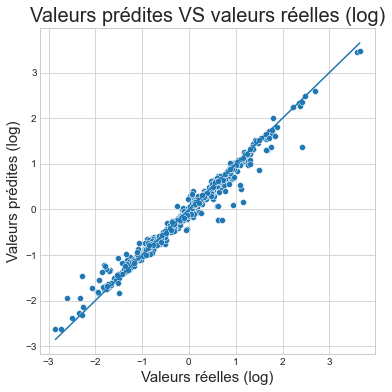

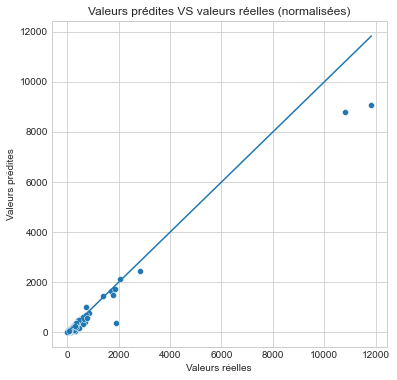

MSE = 0.02
RMSE = 0.16
Coefficient de détermination = 0.97


In [212]:
np.random.seed(5)
param_rfr_opti = { 
    'n_estimators': [300],
    'max_features': ['sqrt'],
    'max_depth' : [None],
    'bootstrap' : [False]
}
rfr_ESS = GridSearchCV(RandomForestRegressor(),
                       param_grid = param_rfr_opti,
                       verbose = 2,
                       cv = cv_train,
                       scoring = score,
                       refit = 'neg_mean_absolute_error',
                       return_train_score = True,
                       n_jobs = -1
                      )
rfr_ESS.fit(X_train_ESS, y_train_ESS)
pred_rfr_ESS = rfr_ESS.predict(X_test_ESS)
fit_time_rfr_ESS = rfr_ESS.cv_results_['mean_fit_time'].mean()
pred_time_rfr_ESS = rfr_ESS.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_rfr_ESS))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_rfr_ESS))


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_ESS, y = pred_rfr_ESS)
plt.plot([y_test_ESS.min(), y_test_ESS.max()], [y_test_ESS.min(), y_test_ESS.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()


fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_ESS_['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_ESS.inverse_transform(pred_rfr_ESS.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_ESS_['TotalGHGEmissions(Tons)'].min(), X_test_ESS_['TotalGHGEmissions(Tons)'].max()],
         [X_test_ESS_['TotalGHGEmissions(Tons)'].min(), X_test_ESS_['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()


MSE_rfr_ESS = mean_squared_error(y_test_ESS, pred_rfr_ESS, squared=True)
print('MSE = {:.2f}'.format(MSE_rfr_ESS))
print('RMSE = {:.2f}'.format(MSE_rfr_ESS**(1/2)))

R2_rfr_ESS = r2_score(y_test_ESS, pred_rfr_ESS)
print('Coefficient de détermination = {:.2f}'.format(R2_rfr_ESS))

**2. Avec ré-optimisation**

In [213]:
np.random.seed(5)
rfr_ESS2 = GridSearchCV(RandomForestRegressor(),
                        param_grid = param_rfr,
                        verbose = 2,
                        cv = cv_train,
                        scoring = score,
                        refit = 'neg_mean_absolute_error',
                        return_train_score = True,
                        n_jobs = -1
                       )

In [214]:
rfr_ESS2.fit(X_train_ESS, y_train_ESS)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 15, 20, 25, 30, 35, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 500, 800, 1000, 1200]},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [215]:
pred_rfr_ESS2 = rfr_ESS2.predict(X_test_ESS)

In [216]:
fit_time_rfr_ESS2 = rfr_ESS2.cv_results_['mean_fit_time'].mean()
pred_time_rfr_ESS2 = rfr_ESS2.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_rfr_ESS2))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_rfr_ESS2))

Temps écoulé pour l'entraînement = 4.51s
Temps écoulé pour la prédiction = 0.12s


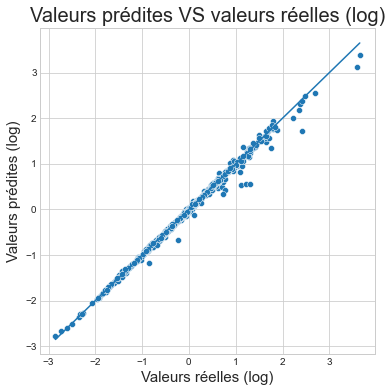

In [217]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = y_test_ESS, y = pred_rfr_ESS2)
plt.plot([y_test_ESS.min(), y_test_ESS.max()], [y_test_ESS.min(), y_test_ESS.max()])
plt.title("Valeurs prédites VS valeurs réelles (log)", fontsize = 20)
plt.xlabel("Valeurs réelles (log)", fontsize = 15)
plt.ylabel("Valeurs prédites (log)", fontsize = 15)
plt.show()

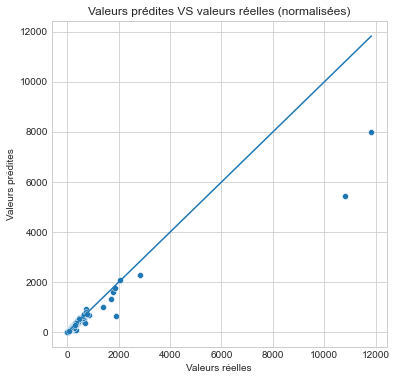

In [218]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_test_ESS_['TotalGHGEmissions(Tons)'], y = np.exp(std_scale_y_ESS.inverse_transform(pred_rfr_ESS2.reshape(-1, 1))).reshape(-1, ))
plt.plot([X_test_ESS_['TotalGHGEmissions(Tons)'].min(), X_test_ESS_['TotalGHGEmissions(Tons)'].max()],
         [X_test_ESS_['TotalGHGEmissions(Tons)'].min(), X_test_ESS_['TotalGHGEmissions(Tons)'].max()])
plt.title("Valeurs prédites VS valeurs réelles (normalisées)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.show()

In [219]:
MSE_rfr_ESS2 = mean_squared_error(y_test_ESS, pred_rfr_ESS2, squared=True)
print('MSE = {:.2f}'.format(MSE_rfr_ESS2))
print('RMSE = {:.2f}'.format(MSE_rfr_ESS2**(1/2)))

R2_rfr_ESS2 = r2_score(y_test_ESS, pred_rfr_ESS2)
print('Coefficient de détermination = {:.2f}'.format(R2_rfr_ESS2))

MSE = 0.01
RMSE = 0.08
Coefficient de détermination = 0.99


[Retour au sommaire](#Sommaire)
### Comparaison des modèles <a class="anchor" id="Partie4_3"></a>

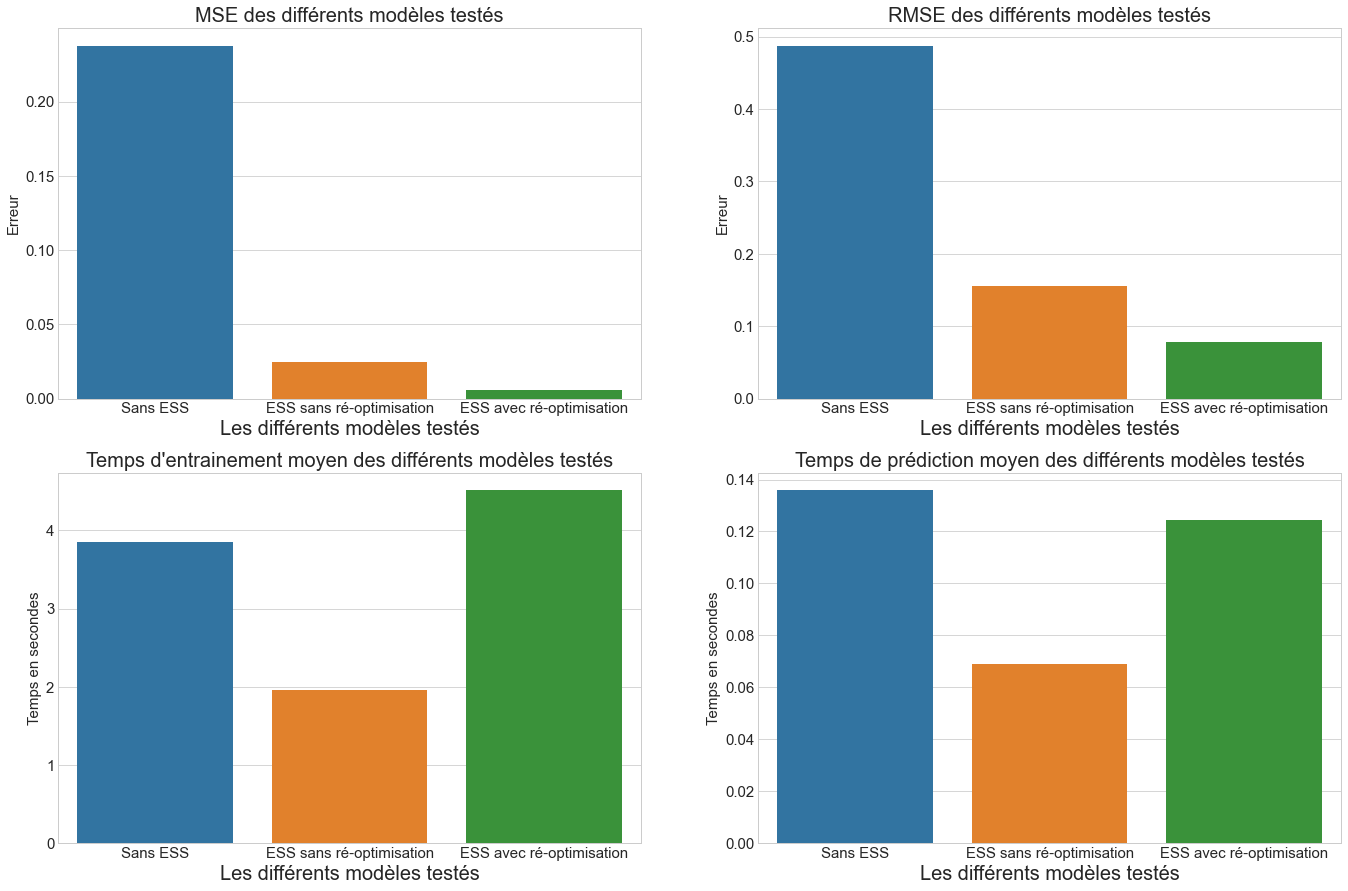

In [220]:
fig = plt.figure(figsize = (23, 15))
listeModeles = ['Sans ESS', 'ESS sans ré-optimisation', 'ESS avec ré-optimisation']

listeMSE = [MSE_rfr_CO2, MSE_rfr_ESS, MSE_rfr_ESS2]
listeRMSE = [elt**(1/2) for elt in listeMSE]
listeFitTime = [fit_time_rfr_CO2, fit_time_rfr_ESS, fit_time_rfr_ESS2]
listePredTime = [pred_time_rfr_CO2, pred_time_rfr_ESS, pred_time_rfr_ESS2]

plt.subplot(2,2,1)
sns.barplot(x = listeModeles, y = listeMSE)
plt.title('MSE des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,2)
sns.barplot(x = listeModeles, y = listeRMSE)
plt.title('RMSE des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,3)
sns.barplot(x = listeModeles, y = listeFitTime)
plt.title('Temps d\'entrainement moyen des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Temps en secondes', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,4)
sns.barplot(x = listeModeles, y = listePredTime)
plt.title('Temps de prédiction moyen des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Temps en secondes', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

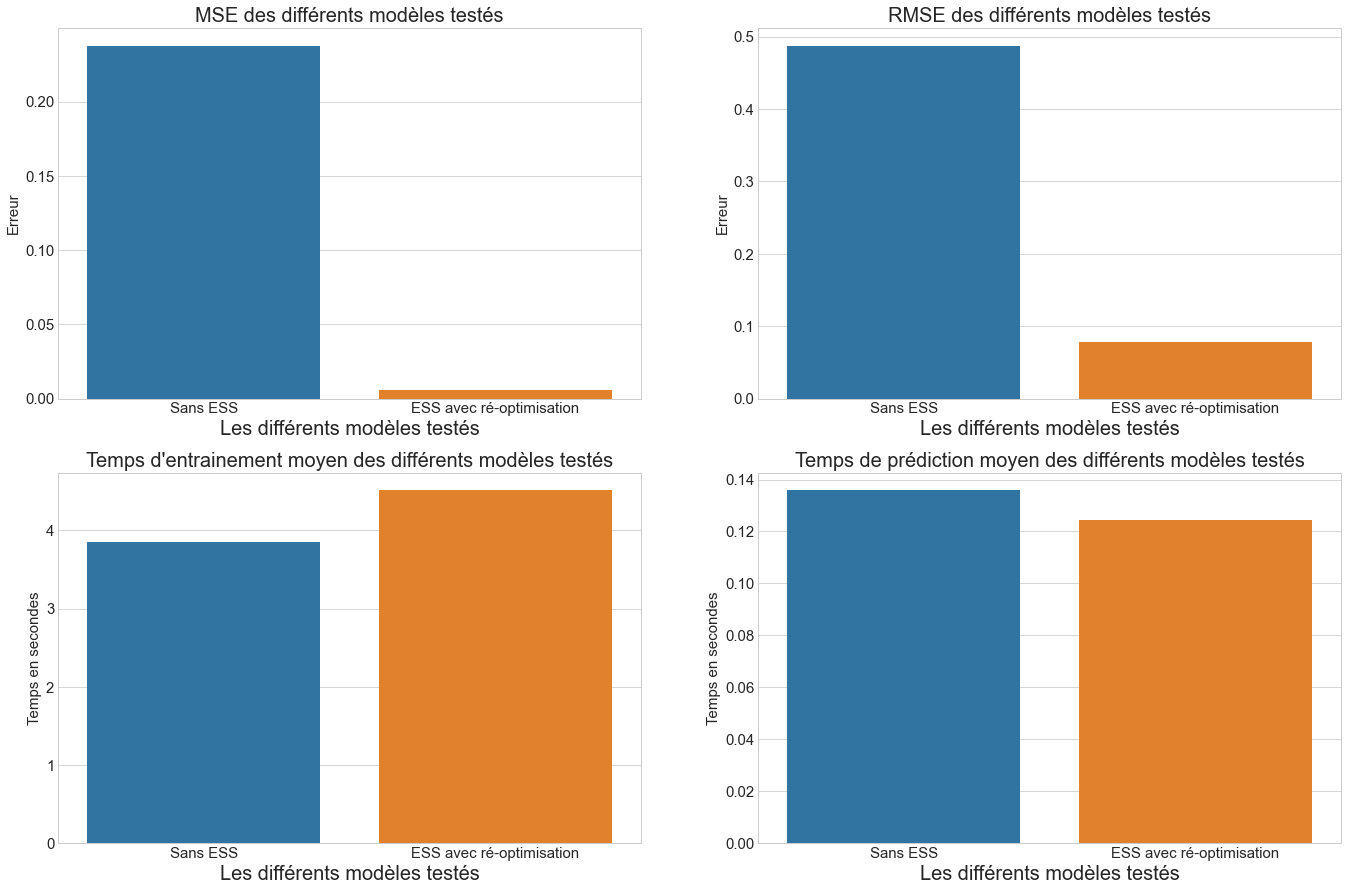

In [221]:
fig = plt.figure(figsize = (23, 15))
listeModeles = ['Sans ESS','ESS avec ré-optimisation']

listeMSE = [MSE_rfr_CO2,  MSE_rfr_ESS2]
listeRMSE = [elt**(1/2) for elt in listeMSE]
listeFitTime = [fit_time_rfr_CO2,  fit_time_rfr_ESS2]
listePredTime = [pred_time_rfr_CO2, pred_time_rfr_ESS2]

plt.subplot(2,2,1)
sns.barplot(x = listeModeles, y = listeMSE)
plt.title('MSE des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,2)
sns.barplot(x = listeModeles, y = listeRMSE)
plt.title('RMSE des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,3)
sns.barplot(x = listeModeles, y = listeFitTime)
plt.title('Temps d\'entrainement moyen des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Temps en secondes', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,4)
sns.barplot(x = listeModeles, y = listePredTime)
plt.title('Temps de prédiction moyen des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Temps en secondes', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

[Retour au sommaire](#Sommaire)